# Direst need of aid Country Clustering  
### Data Understanding and cleaning(EDA) 
### PCA
### K-Means Clustering
### Hierarchical Clustering

In [1]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler

import sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the data set
df = pd.read_csv('Country-data.csv')
df.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [3]:
# check the shape of the dataframe
df.shape

(167, 10)

In [4]:
# check for any duplicates in the country columns
df.duplicated('country').sum()

0

In [5]:
# check for the information details
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


**No missing values noted**

In [6]:
#Converting exports, imports and health from percentages to absolute values.
df['exports'] = df['exports']*df['gdpp']/100
df['imports'] = df['imports']*df['gdpp']/100
df['health'] = df['health']*df['gdpp']/100

In [7]:
# Check for the data distribution. To get an overview of outliers
df.describe(percentiles = [0.25,0.5,0.75,0.90,0.95,0.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


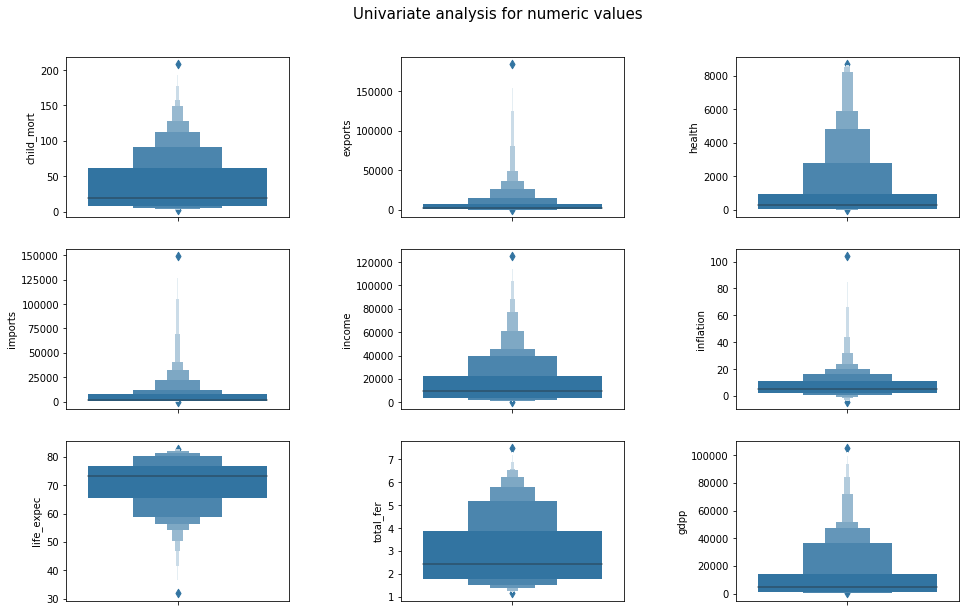

In [8]:
# Univariate analysis on each numerical value from the dataset
fig, axes = plt.subplots(3,3, figsize= (16,10))
count = 0
for i in df.columns[1:]:
    ax = axes[count//3, count%3]
    sns.boxenplot(y = i, data = df, ax = ax)
    count+=1
fig.suptitle('Univariate analysis for numeric values',fontsize=15,x =0.5, y=0.95)
fig.subplots_adjust(wspace=0.5,hspace=0.2 ) # adjust spaces between subplots width and height  

**Check the distribution of the numerical variables! looks some outliers in the columns--> 'export', 'import' ,'income' and 'inflation'. Let's check outliers with PCA PCs, if still there is any outliers with PCA data frame, then we will make outliers treatment on that PCA data frame before proceeding with clusters**

In [9]:
#defined function for filter outliers -- # removing (statistical) outliers
def filter_OutLiers(df,column_name):
    Q1 = df[column_name].quantile(0.05)
    Q3 = df[column_name].quantile(0.95)
    IQR = Q3 - Q1
    df_temp = df.loc[((df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR)))]
    return(df_temp)

In [10]:
#defined function for detecting outliers!
def Detect_OutLiers(df,column_name):
    Q1 = df[column_name].quantile(0.05)
    Q3 = df[column_name].quantile(0.95)
    IQR = Q3 - Q1
    df_temp = df.loc[~((df[column_name] >= (Q1 - 1.5 * IQR)) & (df[column_name] <= (Q3 + 1.5 * IQR)))]
    return(df_temp)

In [11]:
# check the rows/countries removed during outliers treatment. 
df_outliers = pd.DataFrame()

for i in df.columns[1:7]:
    df_loc = Detect_OutLiers(df,i)
    df_outliers = df_outliers.append(df_loc)
    df_outliers = df_outliers.drop_duplicates(keep = 'first')

df_outliers

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
91,Luxembourg,2.8,183750.00,8158.500,149100.00,91700,3.620,81.3,1.63,105000
133,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600
123,Qatar,9.0,43796.90,1272.430,16731.40,125000,6.980,79.5,2.07,70300
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330


**4 countries are detected as outliers. let's not filter these countries right now, proceed with PCA and check once again for outliers.**

In [12]:
# take a copy of the original data frame 
df_fil = df.copy()

In [13]:
# Reset the index after outliers treatment. 
df_fil.reset_index(drop = True, inplace= True)

In [14]:
# final data frame after data quality checks
df_fil.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


### we have considerably more number of columns, it is somehow difficult to find proper cluster and visualization, so we can apply PCA to do dimensional reduction. and also let's check the correlation matrix to check if the variables are highly correlated, if yes then it is indeed to use PCA to avoid multicollinearity..

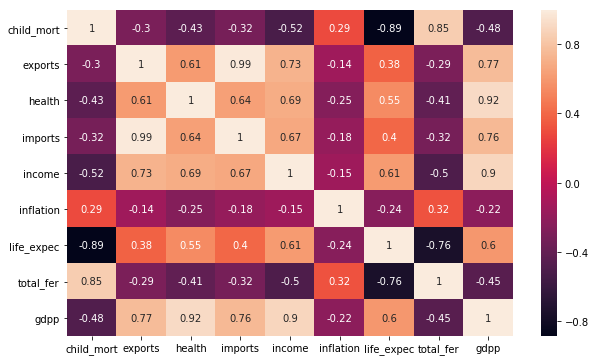

In [15]:
# Correlation matrix heat map  
plt.figure(figsize = (10,6))
sns.heatmap(df_fil.corr(), annot = True) 
plt.show()

### We have a lot of variables are highly correlated with each other. So it is indeed to use PCA on this dataset.

In [16]:
# drop country column and create df_pca data frame for PCA
df_pca = df_fil.drop(columns = 'country', axis = 1)
df_pca.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


In [17]:
# since the variables are having different magnitude, it is necessary to make scaling before PCA.
standard_scaler = StandardScaler()
df_pca_scaled = standard_scaler.fit_transform(df_pca)
df_pca_scaled

array([[ 1.29153238, -0.4110113 , -0.56503989, ..., -1.61909203,
         1.90288227, -0.67917961],
       [-0.5389489 , -0.35019096, -0.43921769, ...,  0.64786643,
        -0.85997281, -0.48562324],
       [-0.27283273, -0.31852577, -0.48482608, ...,  0.67042323,
        -0.0384044 , -0.46537561],
       ...,
       [-0.37231541, -0.36146329, -0.53848844, ...,  0.28695762,
        -0.66120626, -0.63775406],
       [ 0.44841668, -0.39216643, -0.55059641, ..., -0.34463279,
         1.14094382, -0.63775406],
       [ 1.11495062, -0.38395214, -0.54049845, ..., -2.09278484,
         1.6246091 , -0.62954556]])

In [18]:
# create PCA object and apply PCA in the scaled data frame
pca = PCA(random_state=42)
pca.fit(df_pca_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='auto', tol=0.0, whiten=False)

In [19]:
# check the pca components, should be same as number of columns.
pca.components_

array([[-0.31639186,  0.34288671,  0.358535  ,  0.34486492,  0.38004113,
        -0.14308531,  0.34385651, -0.30284224,  0.39998795],
       [ 0.47626735,  0.39731091,  0.1550529 ,  0.37078075,  0.12838448,
         0.22126089, -0.36981973,  0.4597152 ,  0.2006241 ],
       [-0.15001225, -0.03057367, -0.07570322, -0.07217386,  0.14576421,
         0.94841868,  0.19675173, -0.07783431,  0.01033941],
       [-0.14805195,  0.44942527, -0.59971228,  0.46179779, -0.15480592,
        -0.00762798, -0.01839465, -0.21392805, -0.36477239],
       [ 0.1019948 , -0.03853829, -0.49319984, -0.2527867 ,  0.79407469,
        -0.13642345, -0.15404105, -0.02033568,  0.08750149],
       [ 0.19658519, -0.03891112,  0.18069888, -0.01217988, -0.03814681,
         0.10840284, -0.58600986, -0.75390075,  0.04538167],
       [ 0.76126725, -0.01366973, -0.06461567,  0.02718244, -0.02311312,
        -0.02207663,  0.58120846, -0.27314534, -0.04402264],
       [ 0.00644411, -0.05526371,  0.43007213,  0.1311355 ,  0

In [20]:
# check the variance ratios for each component
pca.explained_variance_ratio_

array([5.89372984e-01, 1.84451685e-01, 9.91147170e-02, 6.07227801e-02,
       3.02917253e-02, 2.45982702e-02, 9.39743701e-03, 1.55641971e-03,
       4.93981394e-04])

**Principal component 1 explains the variation of about 59% of the data.
PC2 explains about 18% , PC 3 explains about 10% and PC4 explains about 6%.
In total with 4 principal components, we can explain about  93% variation of the data.**

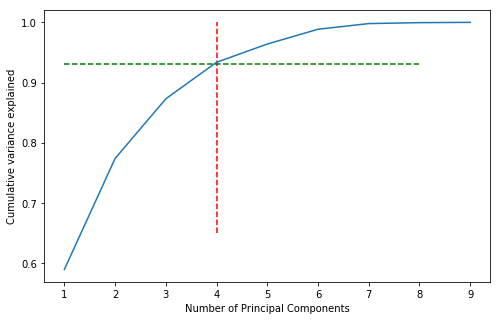

In [21]:
# Plot the variance explained by the principal component.
fig = plt.figure(figsize=[8,5])
plt.vlines(x=4, ymax=1, ymin=0.65, colors="r", linestyles="--")
plt.hlines(y=0.93, xmax=8, xmin=1, colors="g", linestyles="--")
plt.plot(pd.DataFrame(np.cumsum(pca.explained_variance_ratio_),range(1,10)))
plt.ylabel("Cumulative variance explained")
plt.xlabel("Number of Principal Components")
plt.show()

### it looks, with 4 principal components, we are able to explain >90% data. So let's use only these 4 components for making clusters 

In [22]:
# create pca_final object with considering 4 principal components
pca_final = IncrementalPCA(n_components=4)

In [23]:
# fit and transform pca_final on the scaled data
df_pca_final = pca_final.fit_transform(df_pca_scaled)

In [24]:
# check the shape of the data frame after PCA with 4 components
df_pca_final.shape

(167, 4)

In [25]:
# create a correlation matrix
df_pca_corr = np.corrcoef(df_pca_final.transpose())

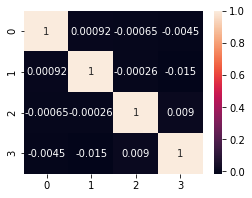

In [26]:
# plot the heat map to check the correlation between components 
plt.figure(figsize=[4,3])
sns.heatmap(df_pca_corr, annot=True)
plt.show()

### It is very clear, that there is no multicollinearity issue with the above data set.

In [27]:
df_pca_cluster = pd.DataFrame(df_pca_final)
df_pca_cluster.columns = ['PC1', 'PC2', 'PC3','PC4']
df_pca_cluster.head()

,PC1,PC2,PC3,PC4
0,-2.636647,1.472085,-0.546500,0.237267
1,-0.023845,-1.435816,-0.009080,-0.442921
2,-0.459260,-0.678794,0.967852,-0.176389
3,-2.723581,2.176018,0.597794,0.438919
4,0.648777,-1.026498,-0.244170,-0.267513


In [28]:
df_pca_cluster.describe()

,PC1,PC2,PC3,PC4
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,4.520669e-17,1.994413e-17,-3.074719e-17,-9.141058e-18
std,2.310042e+00,1.292219e+00,9.468276e-01,7.407949e-01
min,-3.938184e+00,-1.700660e+00,-1.798863e+00,-4.587245e+00
25%,-1.447765e+00,-9.808471e-01,-4.013683e-01,-3.433921e-01
50%,-3.569253e-01,-3.963391e-01,-1.786846e-01,-1.356113e-01
75%,8.501015e-01,6.784442e-01,2.664755e-01,2.237735e-01
max,1.263363e+01,8.219800e+00,7.867898e+00,3.195655e+00


In [29]:
df_pca_cluster.shape

(167, 4)

In [30]:
# create a new data frame: df_cluster_fil for checking outliers treatment! after PCA
df_cluster_fil = df_pca_cluster.copy()
df_cluster_fil['country'] = df['country']
df_cluster_fil.head()

,PC1,PC2,PC3,PC4,country
0,-2.636647,1.472085,-0.546500,0.237267,Afghanistan
1,-0.023845,-1.435816,-0.009080,-0.442921,Albania
2,-0.459260,-0.678794,0.967852,-0.176389,Algeria
3,-2.723581,2.176018,0.597794,0.438919,Angola
4,0.648777,-1.026498,-0.244170,-0.267513,Antigua and Barbuda


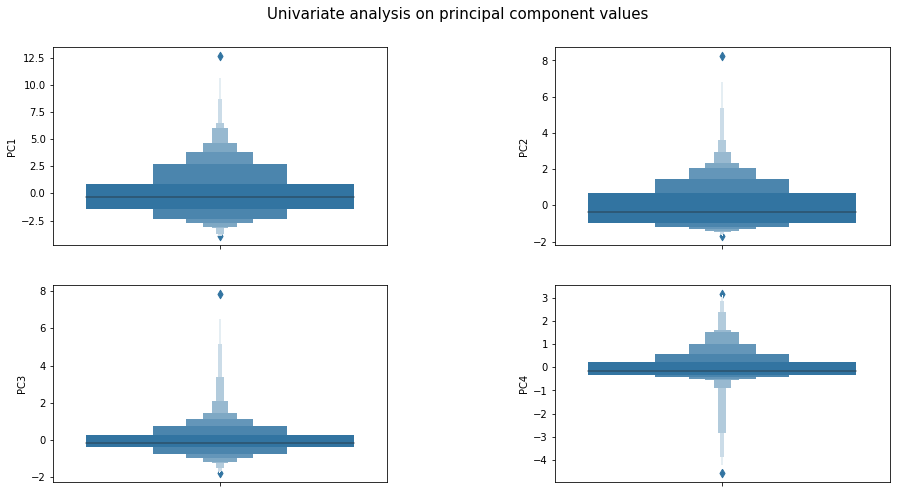

In [31]:
# Univariate analysis of each numerical value from the dataset
fig, axes = plt.subplots(2,2, figsize= (15,8))
count = 0
for i in df_cluster_fil.columns[:-1]:
    ax = axes[count//2, count%2]
    sns.boxenplot(y = i, data = df_cluster_fil, ax = ax)
    count+=1
fig.suptitle('Univariate analysis on principal component values',fontsize=15,x =0.5, y=0.95)
fig.subplots_adjust(wspace=0.5,hspace=0.2 ) # adjust spaces between subplots width and height 

In [32]:
# create a new data frame: df_cluster after outliers treatment! 
# it is important to perform outliers treatment as Kmeans clustering is sensitive to outliers.

df_cluster = df_cluster_fil.copy()

for i in df_cluster_fil.columns[:-1]:
    df_cluster = filter_OutLiers(df_cluster,i).copy()
df_cluster.head()    

,PC1,PC2,PC3,PC4,country
0,-2.636647,1.472085,-0.546500,0.237267,Afghanistan
1,-0.023845,-1.435816,-0.009080,-0.442921,Albania
2,-0.459260,-0.678794,0.967852,-0.176389,Algeria
3,-2.723581,2.176018,0.597794,0.438919,Angola
4,0.648777,-1.026498,-0.244170,-0.267513,Antigua and Barbuda


In [33]:
# dataframe shape checking!
df_cluster.shape

(164, 5)

**167 rows became 164 rows means, 3 outliers found, let's check which countries are filtered with outlier treatment.**

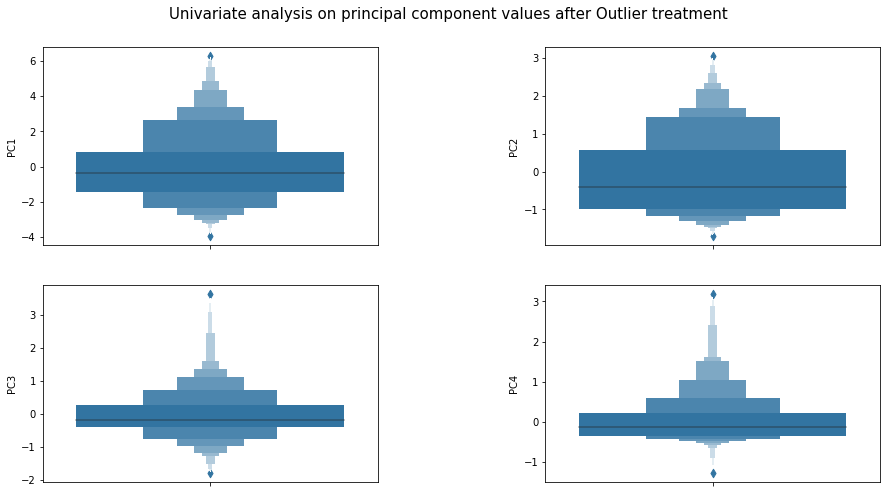

In [34]:
# Check the variables once again after outliers treatment
fig, axes = plt.subplots(2,2, figsize= (15,8))
count = 0
for i in df_cluster.columns[:-1]:
    ax = axes[count//2, count%2]
    sns.boxenplot(y = i, data = df_cluster, ax = ax)
    count+=1
fig.suptitle('Univariate analysis on principal component values after Outlier treatment',fontsize=15,x =0.5, y=0.95)
fig.subplots_adjust(wspace=0.5,hspace=0.2 ) # adjust spaces between subplots width and height 

In [35]:
# check the rows/countries removed during outliers treatment.
df_outliers_PCA = pd.DataFrame()

for i in df_cluster_fil.columns[:-1]:
    df_loc = Detect_OutLiers(df_cluster_fil,i)
    df_outliers_PCA = df_outliers_PCA.append(df_loc)
    df_outliers_PCA = df_outliers_PCA.drop_duplicates(keep = 'first')

df_outliers_PCA

,PC1,PC2,PC3,PC4,country
91,12.633634,8.219800,-0.571184,-4.587245,Luxembourg
113,-3.931333,3.825005,7.867898,0.576284,Nigeria
133,6.582494,2.913633,-0.224591,-3.496339,Singapore


**Luxembourg, Nigeria, and Singapore detected as outliers.**

In [36]:
# removed the country list from the df_cluster data frame to perform clustering further.
country_list = df_cluster.pop('country')
df_cluster.head()

,PC1,PC2,PC3,PC4
0,-2.636647,1.472085,-0.546500,0.237267
1,-0.023845,-1.435816,-0.009080,-0.442921
2,-0.459260,-0.678794,0.967852,-0.176389
3,-2.723581,2.176018,0.597794,0.438919
4,0.648777,-1.026498,-0.244170,-0.267513


### Create a data frame and name the columns with PC1, PC2, PC3, and PC4. Let's make Hopkins test to check how much this data frame is good for clustering

In [37]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [38]:
#Use the Hopkins Statistic function to check how good the above data frame to make clusters.
hopkins(df_cluster)

0.8779663739369643

### Hopkins test result: data frame is good for clustering

### Plot elbow curve on the data set to visualize how may clusters are good fit to proceed

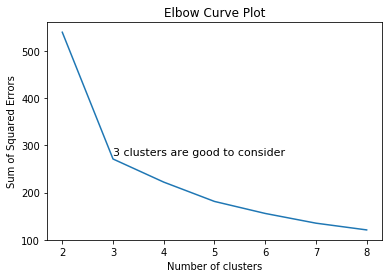

In [39]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_cluster)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
#plt.plot(ssd)
plt.plot(pd.DataFrame(ssd,range_n_clusters))
plt.text(3,280,'3 clusters are good to consider',fontsize=11)
plt.ylabel('Sum of Squared Errors')
plt.xlabel('Number of clusters')
plt.title('Elbow Curve Plot')
plt.show()

### From the above plot. it shows 3 cluster are good to consider!

In [40]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_cluster)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_cluster, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))   

For n_clusters=2, the silhouette score is 0.4817803137425799
For n_clusters=3, the silhouette score is 0.48964509747394136
For n_clusters=4, the silhouette score is 0.4519022809935875
For n_clusters=5, the silhouette score is 0.37780655804401375
For n_clusters=6, the silhouette score is 0.3739544262316014
For n_clusters=7, the silhouette score is 0.3571102700259757
For n_clusters=8, the silhouette score is 0.33787051919496675


### Check the silhouette score to find the best possible clusters. cluster 3 having a good score than others. So considering elbow plot together with these scores, we may go ahead with 3 clusters.

## K Means Clustering

In [41]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50,random_state=42)
kmeans.fit(df_cluster)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [42]:
# Check the labels 
kmeans.labels_

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2,
       2, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       2, 0, 0, 1, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [43]:
# assign the cluster id and countries to the data set
df_cluster_kmeans = df_cluster.copy()
df_cluster_kmeans['cluster_id'] = kmeans.labels_
df_cluster_kmeans['country'] = country_list
df_cluster_kmeans.head()

,PC1,PC2,PC3,PC4,cluster_id,country
0,-2.636647,1.472085,-0.546500,0.237267,0,Afghanistan
1,-0.023845,-1.435816,-0.009080,-0.442921,1,Albania
2,-0.459260,-0.678794,0.967852,-0.176389,1,Algeria
3,-2.723581,2.176018,0.597794,0.438919,0,Angola
4,0.648777,-1.026498,-0.244170,-0.267513,1,Antigua and Barbuda


In [44]:
# check for any null values.
df_cluster_kmeans.isnull().sum()

PC1           0
PC2           0
PC3           0
PC4           0
cluster_id    0
country       0
dtype: int64

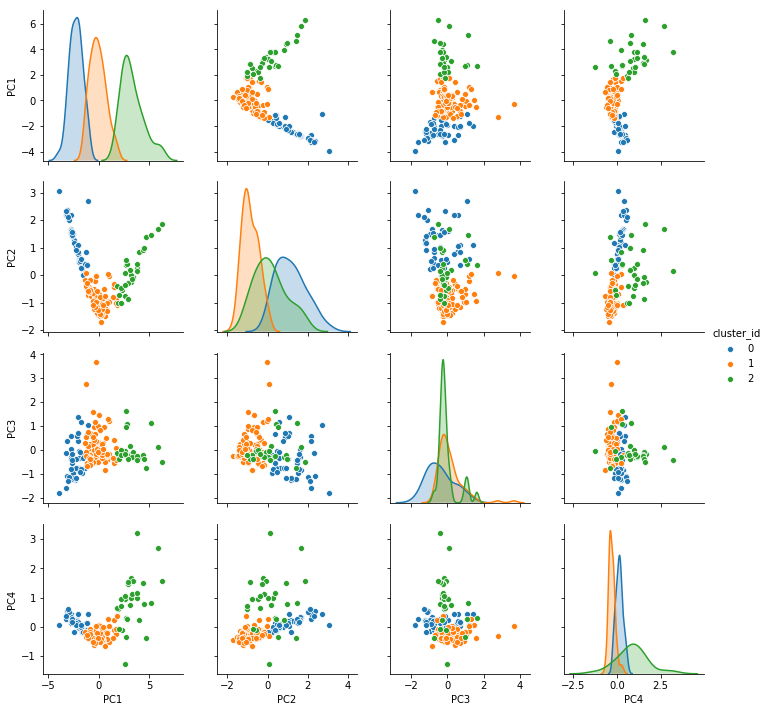

In [45]:
#Check the PCA PCs visualization, about to check how good clusters are formed using pair plot.
pca_col_list = ['PC1','PC2','PC3','PC4']
sns.pairplot(data = df_cluster_kmeans,x_vars= pca_col_list,y_vars=pca_col_list, hue = 'cluster_id')
plt.show()

**Note: data distribution with respect to clusters is good.**

In [46]:
# check the head of the original dataframe
df_fil.head(2)

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.3,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.2,267.8950,1987.740,9930,4.49,76.3,1.65,4090


In [47]:
# check the head of the final kmeans clusters dataframe
df_cluster_kmeans.head(2)

,PC1,PC2,PC3,PC4,cluster_id,country
0,-2.636647,1.472085,-0.54650,0.237267,0,Afghanistan
1,-0.023845,-1.435816,-0.00908,-0.442921,1,Albania


In [48]:
# Assing the cluster labels to the filtered original data set to make some visualizations
df_fil_kmeans = pd.merge(df_fil,df_cluster_kmeans, how= 'inner', on = 'country')
df_fil_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,-2.636647,1.472085,-0.546500,0.237267,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,-0.023845,-1.435816,-0.009080,-0.442921,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,-0.459260,-0.678794,0.967852,-0.176389,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,-2.723581,2.176018,0.597794,0.438919,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0.648777,-1.026498,-0.244170,-0.267513,1


In [49]:
# drop the PCs from the data frame
df_fil_kmeans.drop(pca_col_list, axis =1, inplace = True)
df_fil_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


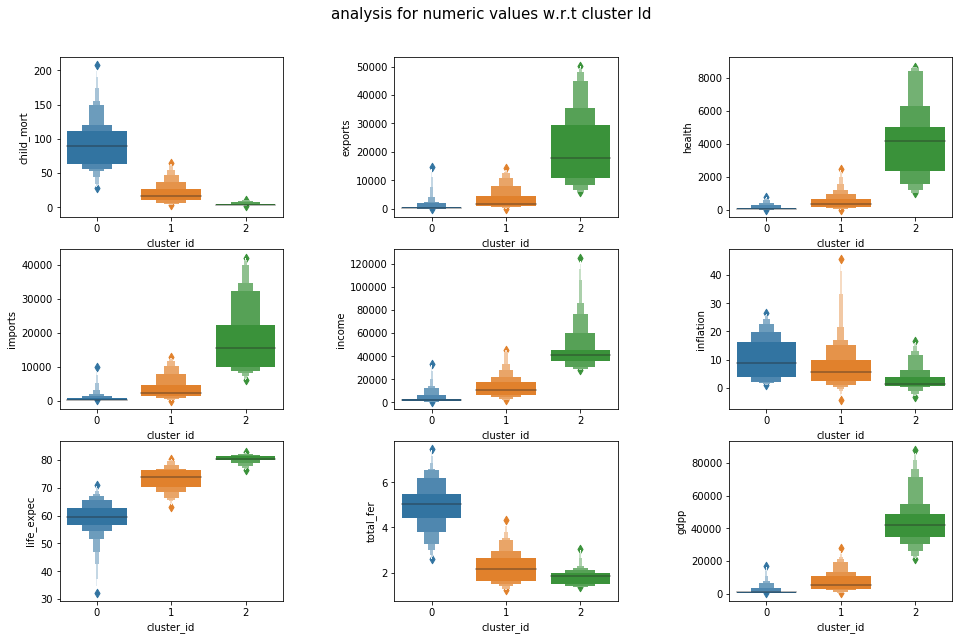

In [50]:
# data distribution using box plots with respect to clusters
fig, axes = plt.subplots(3,3, figsize= (16,10))
count = 0
for i in df_fil_kmeans.columns[1:-1]:
    ax = axes[count//3, count%3]
    sns.boxenplot(y = i, data = df_fil_kmeans, ax = ax, x = 'cluster_id')
    count+=1
fig.suptitle('analysis for numeric values w.r.t cluster Id',fontsize=15,x =0.5, y=0.95)
fig.subplots_adjust(wspace=0.5,hspace=0.2 ) # adjsut spaces between subplots width and height  

**Note: It is clearly seen from the above plots, that cluster 2 indicates developed countries, cluster 1 indicates developing countries and cluster 0 indicates underdeveloped countries. form our business point of view, we are having more concern on cluster 0 to find those countries list, needs support from HELP.** 

In [51]:
# check the mean of all variables data separately with respect to clusters
df_fil_kmeans.groupby('cluster_id').mean().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,90.79,885.22,114.75,836.00,3870.70,9.95,59.21,4.97,1900.26
1,20.92,3366.78,482.90,3461.44,13455.57,7.30,73.22,2.24,7332.64
2,5.08,21511.10,4084.97,18129.90,45800.00,2.84,80.40,1.81,44017.24


**From the above values:  We can clearly say   
`cluster 0` : 'child_mort' is very high ; 'income' is very less ; 'gdpp' is very less  
`cluster 1` : 'child_mort' risk is modarate ; 'income' is middle range ; 'gdpp' is middle in range  
`cluster 2` : 'child_mort' is very less ; 'income' is very high ; 'gdpp' is very high**  

In [52]:
# we make outer merge to original data frame and df_fil_kmeans. 
# by doing this, we expect some missing values in 'cluster_id', 
# as we try to get the countries which are removed during outlier treatment, now with this those will back to data frame

df_original_with_kmeans = pd.merge(df_fil,df_fil_kmeans[['country','cluster_id']],how='outer',on= 'country')

In [53]:
# check the dataframe shape, should be 167 rows.
df_original_with_kmeans.shape

(167, 11)

In [54]:
# check for missing values, expect to have 3 missing values from "cluster_id", 
# as we added those countries back to the data frame, which was filtered during outliers treatment.
df_original_with_kmeans.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    3
dtype: int64

In [55]:
# check the countries having missing cluster_id, let's recall that, we removed 3 countries during outlier treatment.
# 'Luxembourg', 'Nigeria' & 'Singapore'

df_original_with_kmeans.loc[df_original_with_kmeans['cluster_id'].isnull()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
91,Luxembourg,2.8,183750.00,8158.500,149100.00,91700,3.620,81.3,1.63,105000,NaN
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330,NaN
133,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600,NaN


***this is very clear from the data visualization and the mean values. "Nigeria will come under cluster 0 and remaining 2 countries will come under cluster 2. let's take "child_mort" column to impute NaN values***

In [56]:
values =[]
for i in df_original_with_kmeans.values:
    if (abs(i[1]-90.79) < abs(i[1]-5.08)) & (abs(i[1]-90.79) < abs(i[1]-20.92)):
        values.append(0)
    elif (abs(i[1]-5.08) < abs(i[1]-90.79)) & (abs(i[1]-5.08) < abs(i[1]-20.92)):
        values.append(2)
    else:
        values.append(1)
        
# create columns in the data frame to impute missing values in cluster id
df_original_with_kmeans['values'] = values

In [57]:
df_original_with_kmeans.loc[df_original_with_kmeans['cluster_id'].isnull()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,values
91,Luxembourg,2.8,183750.00,8158.500,149100.00,91700,3.620,81.3,1.63,105000,NaN,2
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330,NaN,0
133,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600,NaN,2


**as per our understanding, the values are giving correct cluster numbers for these missing value countries. so we can impute NaN with corresponding values from Values column**

In [58]:
# Impute the missing values of cluster_id from values column
df_original_with_kmeans['cluster_id'].replace(to_replace=np.nan, value = df_original_with_kmeans['values'],inplace= True)

In [59]:
# check for missing values
df_original_with_kmeans.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    0
values        0
dtype: int64

In [60]:
#drop the values columns!.
df_original_with_kmeans.drop(columns = 'values', inplace = True)

**Derive Human Development Index ( HDI ):**  
***1.HDI calculation comes out from the "life expectancy index", "Education index" and "Income index".  
2.Since we don't have any details about the "Education index", we try to calculate the geometric mean of "life expectancy index" and "Income index"***
  
**reference link: https://en.wikipedia.org/wiki/Human_Development_Index**



In [61]:
# Life Expectancy Index ( LEI) = (life_expec-20) / 85-20
# LEI is 1 when Life expectancy at birth is 85 and 0 when Life expectancy at birth is 20.

LEI = (df_original_with_kmeans['life_expec'] - 20)/65

# Income index (Income_index) = ln(gdpp) -ln(100)/ ln(75000) - ln(100)
# Income_index is 1 when gdp per capita is 75,000 and 0 when GNI per capita is 100.

Income_index =(np.log(df_original_with_kmeans['gdpp']) - np.log(100)) / (np.log(75000) - np.log(100))

# HDI is the geometric mean of the previous two normalized indices ( 'LEI' & 'Income_index')
df_original_with_kmeans['HDI'] = np.sqrt(LEI*Income_index).round(2)
df_original_with_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,HDI
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0.0,0.38
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1.0,0.70
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1.0,0.71
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0.0,0.58
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1.0,0.80


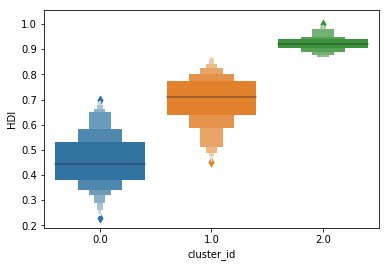

In [62]:
# Plot the HDI, the derived metric with respect to clusters.
sns.boxenplot(y = 'HDI', data = df_original_with_kmeans, x = 'cluster_id')
plt.show()

**It is very clear that, cluster 0: underdevelopment countries, cluster 1: developing countries and cluster 2: developed countries**

In [63]:
# create a dictionary of cluster labels and apply on clusters id columns
cluster_lables_dict = dict({0:'Under_develop_countries', 1:'Developing_countries',2:'Developed_countries'})
df_original_with_kmeans['cluster_id'] = df_original_with_kmeans['cluster_id'].apply(lambda X:cluster_lables_dict[X])

In [64]:
# check the countries' distribution among the clusters. Underdeveloped countries are 48
df_original_with_kmeans.groupby('cluster_id').count()['country']

cluster_id
Developed_countries        31
Developing_countries       88
Under_develop_countries    48
Name: country, dtype: int64

**List of countries direst need of aid is 48. let's make the further check with respect to HDI values, to make priorities in consideration**

In [65]:
# check the data frame head
df_original_with_kmeans.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,HDI
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,Under_develop_countries,0.38
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,Developing_countries,0.70
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,Developing_countries,0.71
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,Under_develop_countries,0.58
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,Developing_countries,0.80


### Business aspect: we need to make analysis by considering 'child_mort', 'heath', 'income', 'life_expec', 'gdpp' and 'HDI'

In [66]:
# filter the columns, considering as per business aspects and create the list of columns for use in making pair plots.
columns_list_pairplot = df_original_with_kmeans.columns[1:].drop(['exports','imports','inflation','total_fer','cluster_id'])
columns_list_pairplot

Index(['child_mort', 'health', 'income', 'life_expec', 'gdpp', 'HDI'], dtype='object')

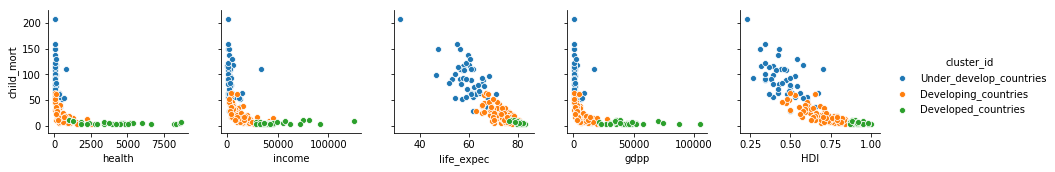

In [67]:
# scatter plot of child_mort with respect to 'health','income','life_expec','gdpp','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('child_mort')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='child_mort', 
                            hue='cluster_id')
plt.show()

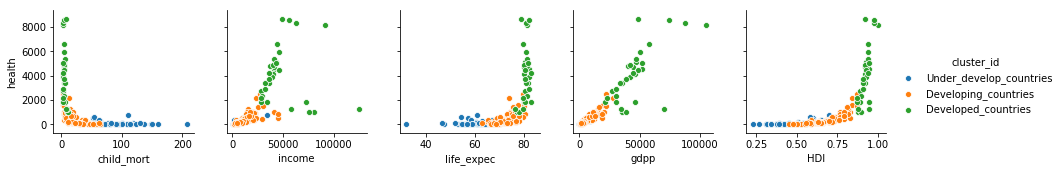

In [68]:
# scatter plot of health with respect to 'child_mort','income','life_expec','gdpp','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('health')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='health', 
                            hue='cluster_id')
plt.show()

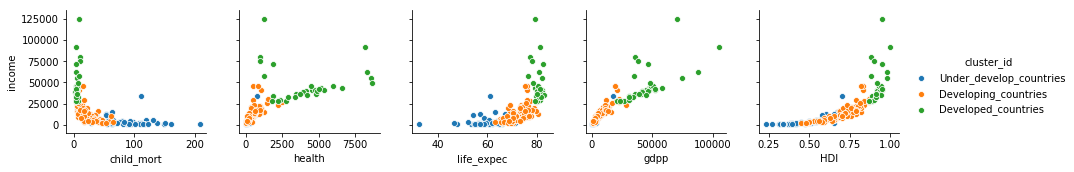

In [69]:
# scatter plot of income with respect to 'child_mort','health','life_expec','gdpp','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('income')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='income', 
                            hue='cluster_id')
plt.show()

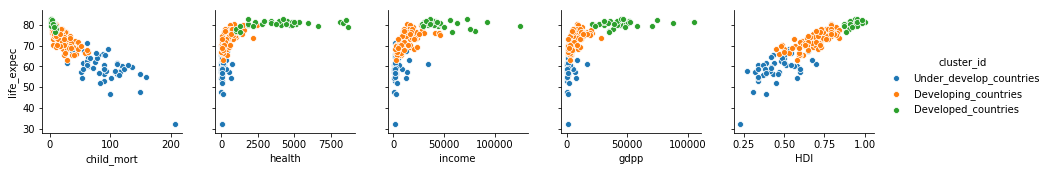

In [70]:
# scatter plot of life_expec with respect to 'child_mort','health','income','gdpp','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('life_expec')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='life_expec', 
                            hue='cluster_id')
plt.show()

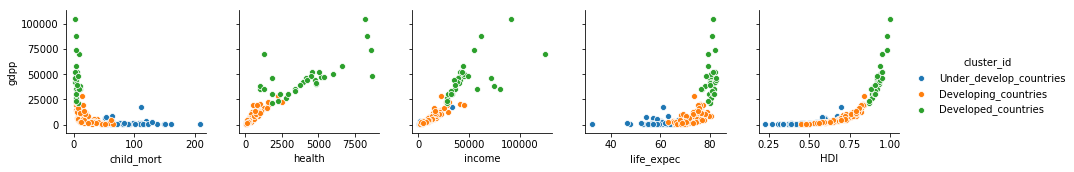

In [71]:
# scatter plot of gdpp with respect to 'child_mort','health','income','life_expec','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('gdpp')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='gdpp', 
                            hue='cluster_id')
plt.show()

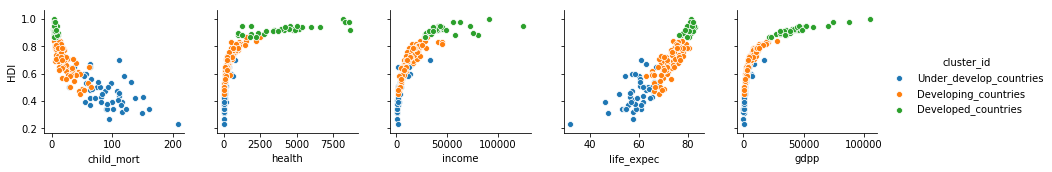

In [72]:
# scatter plot of gdpp with respect to 'child_mort','health','income','life_expec','HDI'
temp_colums_list_pairplot = columns_list_pairplot.drop('HDI')
fig_pairplot = sns.pairplot(data = df_original_with_kmeans,x_vars =temp_colums_list_pairplot,y_vars ='HDI', 
                            hue='cluster_id')
plt.show()

In [73]:
# check the median values of each cluster, HDI mean is 0.46 for underdeveloped countries
df_original_with_kmeans.groupby('cluster_id').mean().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,HDI
cluster_id,,,,,,,,,,
Developed_countries,4.94,29057.15,4144.13,24385.52,48129.03,2.77,80.51,1.79,46067.74,0.92
Developing_countries,20.92,3366.78,482.90,3461.44,13455.57,7.30,73.22,2.24,7332.64,0.70
Under_develop_countries,91.61,879.06,114.82,827.03,3897.35,11.91,59.24,4.99,1909.21,0.46


In [74]:
# Create a data frame for Underdeveloped countries.
df_kmeans_UDC = df_original_with_kmeans.loc[df_original_with_kmeans['cluster_id']=='Under_develop_countries']
df_kmeans_UDC.drop(columns= ['exports','imports','inflation','total_fer'], inplace = True)

In [75]:
# check head of the data frame
df_kmeans_UDC.head()

,country,child_mort,health,income,life_expec,gdpp,cluster_id,HDI
0,Afghanistan,90.2,41.9174,1610,56.2,553,Under_develop_countries,0.38
3,Angola,119.0,100.6050,5900,60.1,3530,Under_develop_countries,0.58
17,Benin,111.0,31.0780,1820,61.8,758,Under_develop_countries,0.44
21,Botswana,52.5,527.0500,13300,57.1,6350,Under_develop_countries,0.60
25,Burkina Faso,116.0,38.7550,1430,57.9,575,Under_develop_countries,0.39


In [76]:
#  Store the mean values of the variables into the dictionary. Using this dictionary, 
# we call on the plot to make the mean line with respect to each variable's distribution with respect to countries.

d_ref_values = df_kmeans_UDC.groupby('cluster_id').mean().round(2).reset_index().drop(columns='cluster_id').to_dict('list')
d_ref_values

{'child_mort': [91.61],
 'health': [114.82],
 'income': [3897.35],
 'life_expec': [59.24],
 'gdpp': [1909.21],
 'HDI': [0.46]}

In [77]:
# function for ploting each variables data with respect to countries and return priority 20 countries from each variables data
def barplot_for_each_column_w_r_t_country(df,column,ascending,d_ref_values):
    plt.figure(figsize = (25,5))
    sns.barplot(x= 'country', y = column, data = df.sort_values(column, ascending = ascending))
    plt.xticks(fontsize = 15, rotation = 90)
    plt.yticks(fontsize = 15)
    plt.ylabel(column,fontsize = 16)
    plt.xlabel('Under_Developed_Countries',fontsize = 16)
    plt.axhline(y = d_ref_values[column][0], color = 'r', linestyle = '--')
    plt.title(column+" values with respec to each country along with mean value as reference line",fontsize = 20)
    plt.show()
    
    list_countries = []
    if (ascending):
        list_countries = df.loc[(df[column].values<=d_ref_values[column][0])].sort_values(
            column,ascending=ascending)['country'].head(20).values
    else:
        list_countries = df.loc[(df[column].values>=d_ref_values[column][0])].sort_values(
            column,ascending=ascending)['country'].head(20).values
    
    #list_countries = df.sort_values(column,ascending= ascending)['country'].head(20).values
    print('\033[1m'+'\033[94m'+'Dire need of aid 20 countries list_'+column+':: \n')
    for j in list_countries:
        print(j)
    return(list_countries)

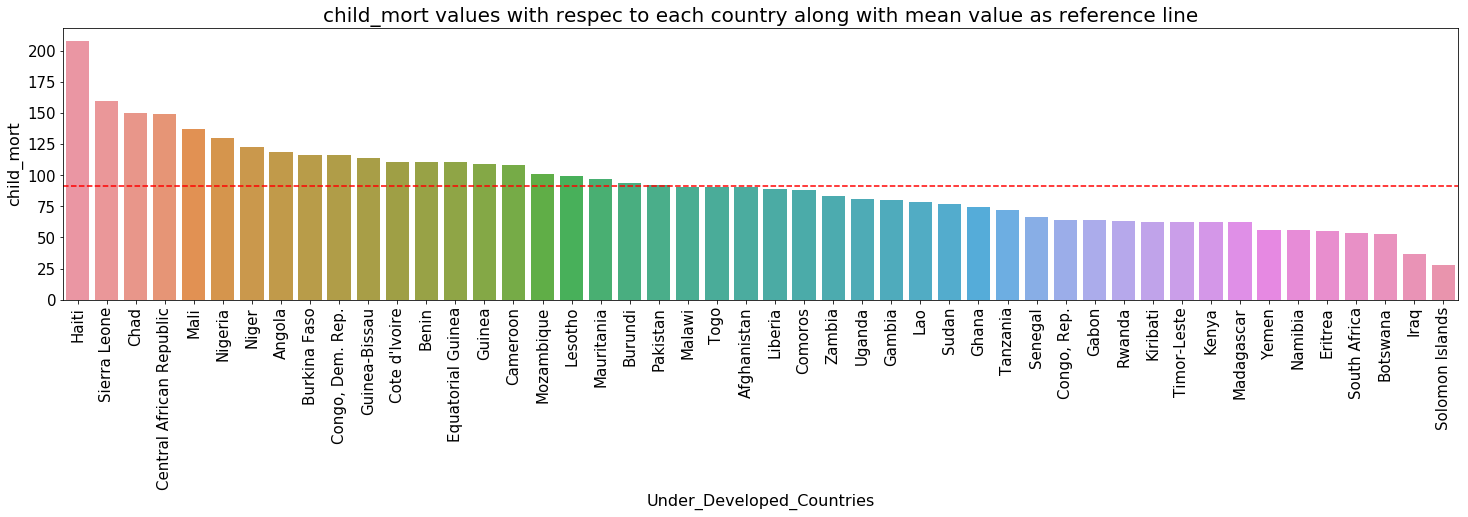

Dire need of aid 20 countries list_child_mort:: 

Haiti
Sierra Leone
Chad
Central African Republic
Mali
Nigeria
Niger
Angola
Congo, Dem. Rep.
Burkina Faso
Guinea-Bissau
Cote d'Ivoire
Equatorial Guinea
Benin
Guinea
Cameroon
Mozambique
Lesotho
Mauritania
Burundi


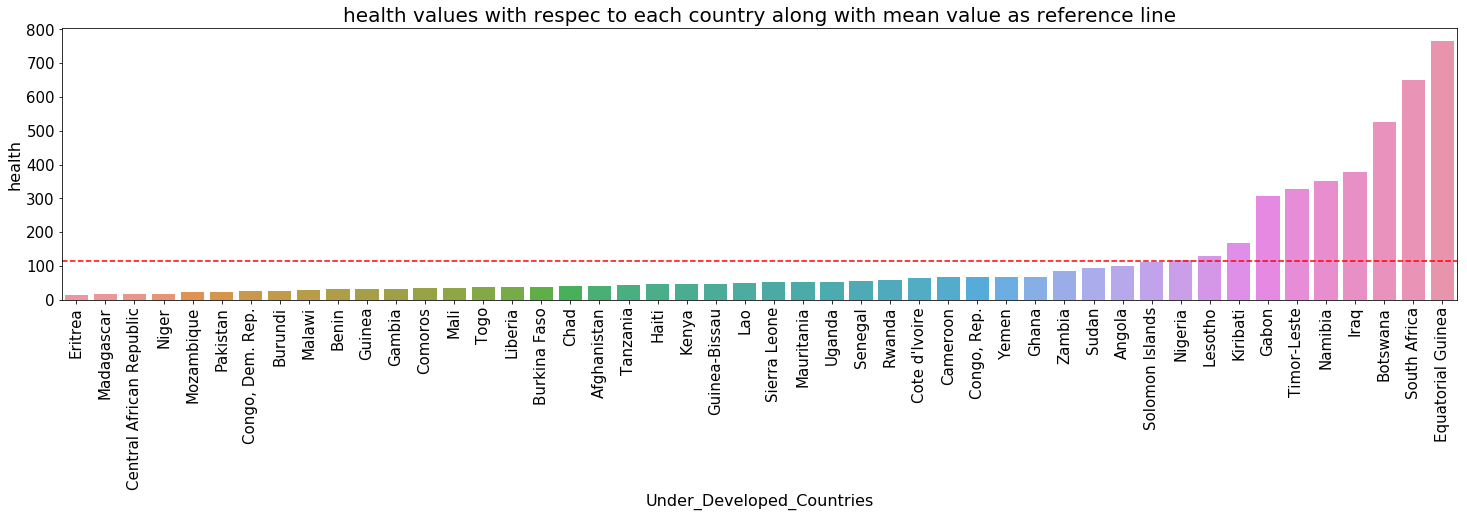

Dire need of aid 20 countries list_health:: 

Eritrea
Madagascar
Central African Republic
Niger
Mozambique
Pakistan
Congo, Dem. Rep.
Burundi
Malawi
Benin
Guinea
Gambia
Comoros
Mali
Togo
Liberia
Burkina Faso
Chad
Afghanistan
Tanzania


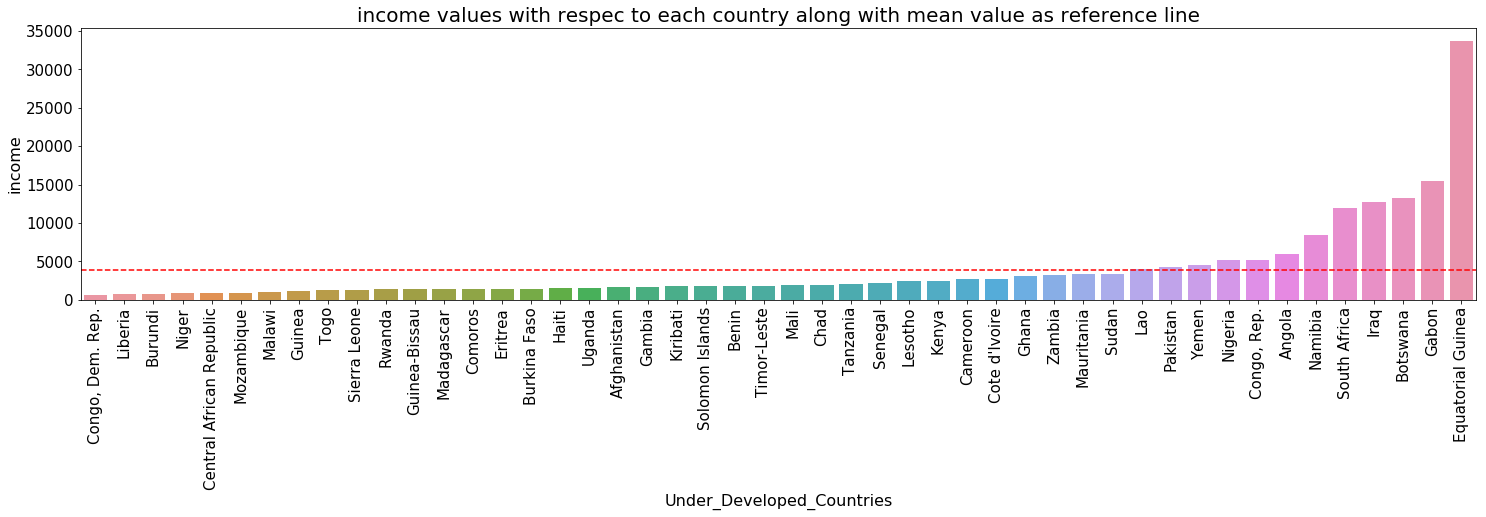

Dire need of aid 20 countries list_income:: 

Congo, Dem. Rep.
Liberia
Burundi
Niger
Central African Republic
Mozambique
Malawi
Guinea
Togo
Sierra Leone
Rwanda
Madagascar
Guinea-Bissau
Comoros
Eritrea
Burkina Faso
Haiti
Uganda
Afghanistan
Gambia


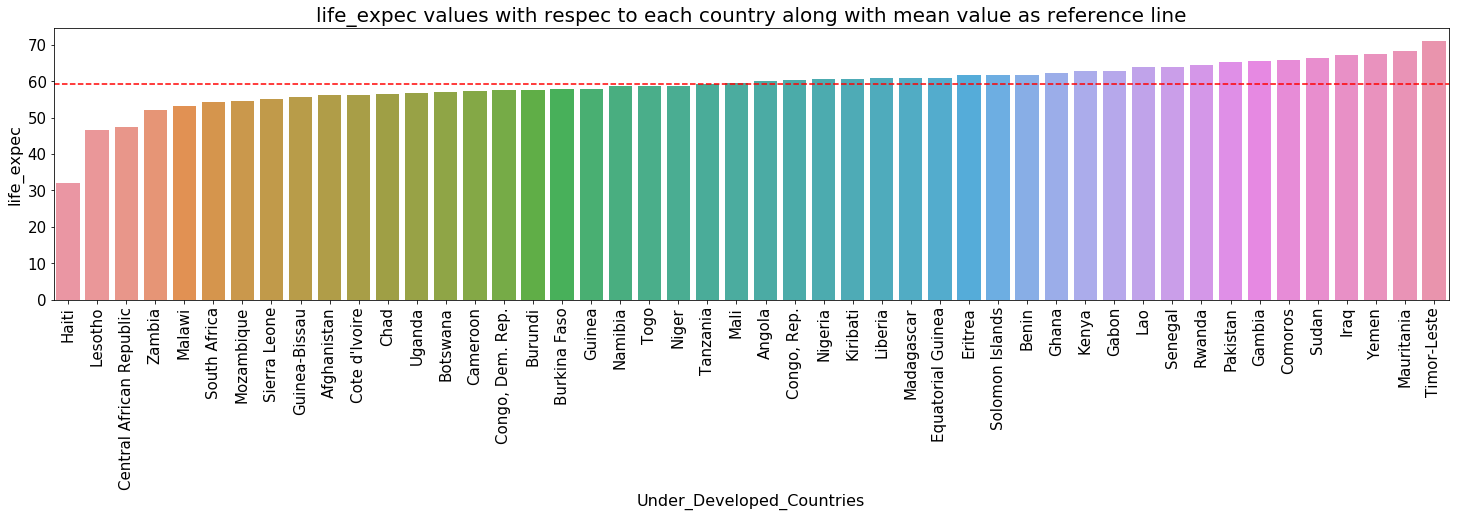

Dire need of aid 20 countries list_life_expec:: 

Haiti
Lesotho
Central African Republic
Zambia
Malawi
South Africa
Mozambique
Sierra Leone
Guinea-Bissau
Afghanistan
Cote d'Ivoire
Chad
Uganda
Botswana
Cameroon
Congo, Dem. Rep.
Burundi
Burkina Faso
Guinea
Namibia


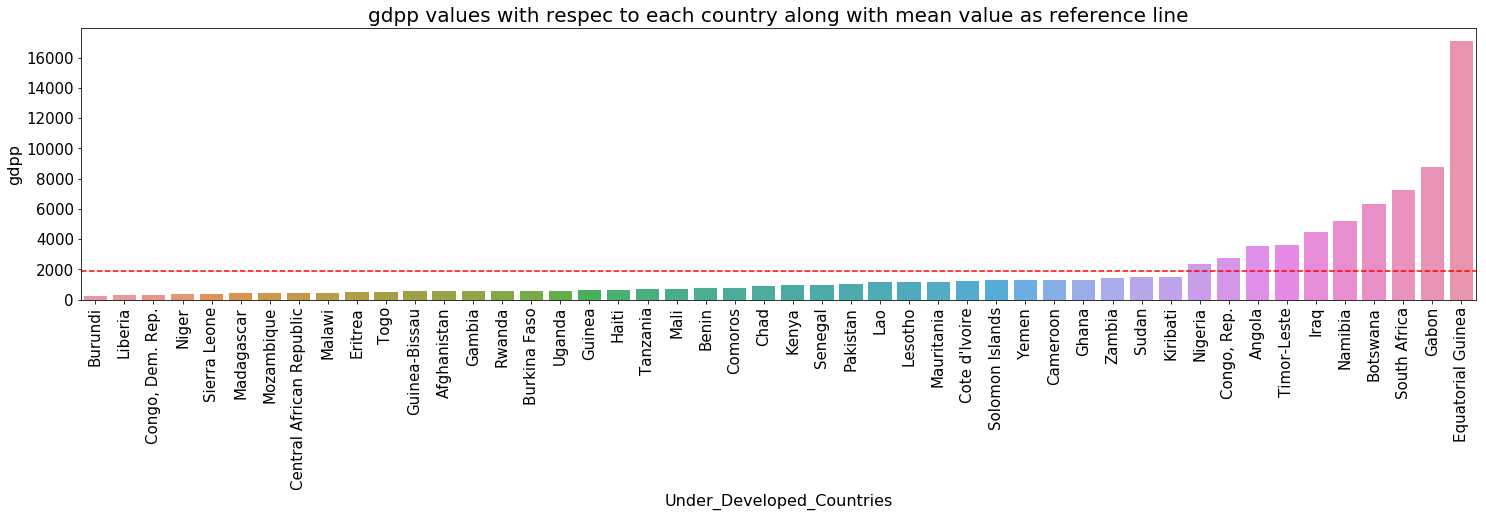

Dire need of aid 20 countries list_gdpp:: 

Burundi
Liberia
Congo, Dem. Rep.
Niger
Sierra Leone
Madagascar
Mozambique
Central African Republic
Malawi
Eritrea
Togo
Guinea-Bissau
Afghanistan
Gambia
Rwanda
Burkina Faso
Uganda
Guinea
Haiti
Tanzania


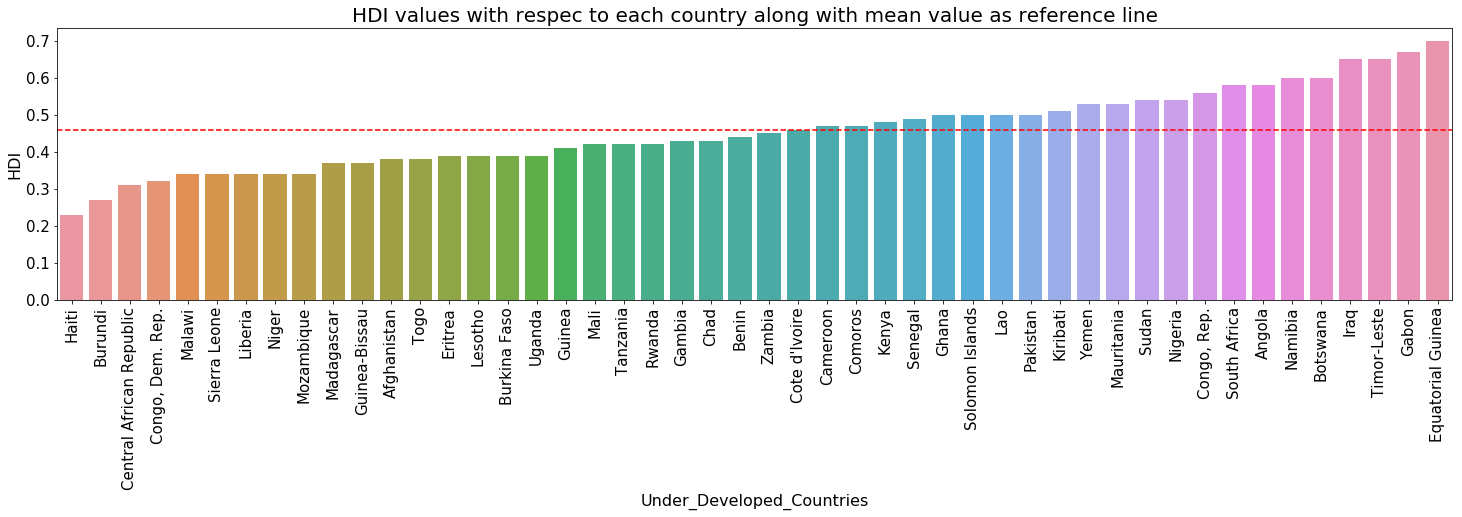

Dire need of aid 20 countries list_HDI:: 

Haiti
Burundi
Central African Republic
Congo, Dem. Rep.
Sierra Leone
Niger
Mozambique
Malawi
Liberia
Madagascar
Guinea-Bissau
Togo
Afghanistan
Lesotho
Eritrea
Burkina Faso
Uganda
Guinea
Mali
Rwanda


In [78]:
Ascend_dict = {1:False,2:True,3:True,4:True,5:True,6:True} # dictionary for assigning True/False to the ascending parameter
count = 1
Kmeans_dire_need_Countries = pd.DataFrame()
for i in columns_list_pairplot:
    Kmeans_dire_need_Countries[i] = barplot_for_each_column_w_r_t_country(df_kmeans_UDC,i,Ascend_dict[count],d_ref_values)
    count = count+1

In [79]:
# list of top 20 countries direst need of aid from each variable
Kmeans_dire_need_Countries

,child_mort,health,income,life_expec,gdpp,HDI
0,Haiti,Eritrea,"Congo, Dem. Rep.",Haiti,Burundi,Haiti
1,Sierra Leone,Madagascar,Liberia,Lesotho,Liberia,Burundi
2,Chad,Central African Republic,Burundi,Central African Republic,"Congo, Dem. Rep.",Central African Republic
3,Central African Republic,Niger,Niger,Zambia,Niger,"Congo, Dem. Rep."
4,Mali,Mozambique,Central African Republic,Malawi,Sierra Leone,Sierra Leone
5,Nigeria,Pakistan,Mozambique,South Africa,Madagascar,Niger
6,Niger,"Congo, Dem. Rep.",Malawi,Mozambique,Mozambique,Mozambique
7,Angola,Burundi,Guinea,Sierra Leone,Central African Republic,Malawi
8,"Congo, Dem. Rep.",Malawi,Togo,Guinea-Bissau,Malawi,Liberia
9,Burkina Faso,Benin,Sierra Leone,Afghanistan,Eritrea,Madagascar


In [80]:
# create the list of countries from the "Kmeans_dire_need_Countries" dataframe
Kmeans_countries_list = []
for i in Kmeans_dire_need_Countries.values:
    for j in i:
        Kmeans_countries_list.append(j)

Need_of_aid_list = list(set(Kmeans_countries_list))
print(Need_of_aid_list)

['Angola', 'Comoros', 'Botswana', 'Guinea', 'Sierra Leone', 'Zambia', 'Togo', 'Haiti', 'Lesotho', 'Guinea-Bissau', 'Burundi', 'Mauritania', 'Rwanda', 'Afghanistan', 'Liberia', 'Tanzania', 'Niger', 'Equatorial Guinea', 'Malawi', 'Eritrea', 'Pakistan', 'Benin', 'Madagascar', 'Chad', 'South Africa', "Cote d'Ivoire", 'Nigeria', 'Namibia', 'Gambia', 'Uganda', 'Congo, Dem. Rep.', 'Central African Republic', 'Mozambique', 'Burkina Faso', 'Mali', 'Cameroon']


In [81]:
#create the list of countries from the "Kmeans_dire_need_Countries" dataframe
df_dire_of_aid = pd.merge(df_kmeans_UDC[['country','HDI']],pd.DataFrame(Need_of_aid_list,columns=['country']),how='inner')

In [82]:
# sort the HDI values to get priorities of countries which we need as per business aspect
df_dire_of_aid.sort_values('HDI', inplace = True)
df_dire_of_aid.head()

,country,HDI
17,Haiti,0.23
5,Burundi,0.27
7,Central African Republic,0.31
10,"Congo, Dem. Rep.",0.32
30,Sierra Leone,0.34


In [83]:
# print the countries direst need of help
print('\033[1m'+'\033[4m'+'\033[92m'+'Dire need of aid '+str(len(df_dire_of_aid.country.values))+
      ' countries list: \n'+'\033[0m')
for i in list(df_dire_of_aid.country.values):
    print('\033[1m'+'\033[92m'+i)

Dire need of aid 36 countries list: 

Haiti
Burundi
Central African Republic
Congo, Dem. Rep.
Sierra Leone
Niger
Mozambique
Malawi
Liberia
Madagascar
Guinea-Bissau
Togo
Afghanistan
Eritrea
Lesotho
Uganda
Burkina Faso
Guinea
Tanzania
Mali
Rwanda
Gambia
Chad
Benin
Zambia
Cote d'Ivoire
Cameroon
Comoros
Pakistan
Mauritania
Nigeria
South Africa
Angola
Namibia
Botswana
Equatorial Guinea


**Need of aid countries listed as per priority wise. Priority considered as per their HDI values. Lowest HDI becomes the highest priority for the direst need of aid and vice versa.**    

## Hierarchical Clustering

In [84]:
# Call the PCA dataframe to use for Hierarchical clustering
df_cluster.head()

,PC1,PC2,PC3,PC4
0,-2.636647,1.472085,-0.546500,0.237267
1,-0.023845,-1.435816,-0.009080,-0.442921
2,-0.459260,-0.678794,0.967852,-0.176389
3,-2.723581,2.176018,0.597794,0.438919
4,0.648777,-1.026498,-0.244170,-0.267513


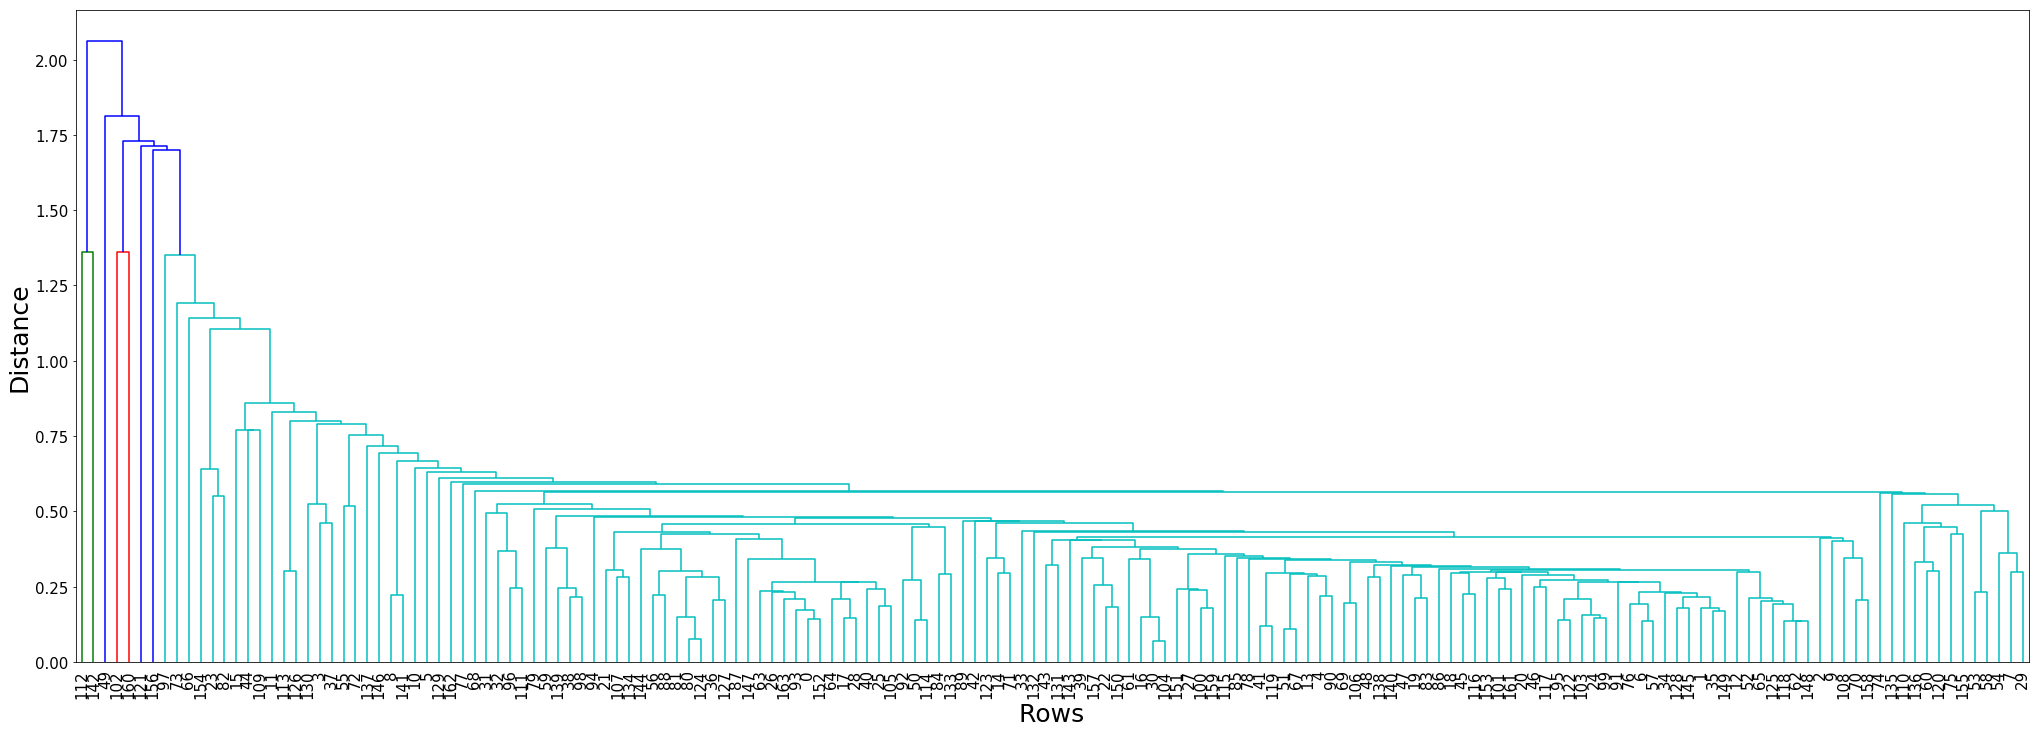

In [85]:
# single linkage
fig = plt.figure(figsize=(35,12))
mergings = linkage(df_cluster, method='single', metric='euclidean')
dendrogram(mergings,leaf_font_size =15)
plt.xlabel('Rows',fontsize = 25)
plt.ylabel('Distance',fontsize = 25)
plt.yticks(fontsize = 15)
plt.show()

**Single linkage hierarchical clustering not formed well, as we can see clearly from the dendrogram. let's try to make a complete linkage method**

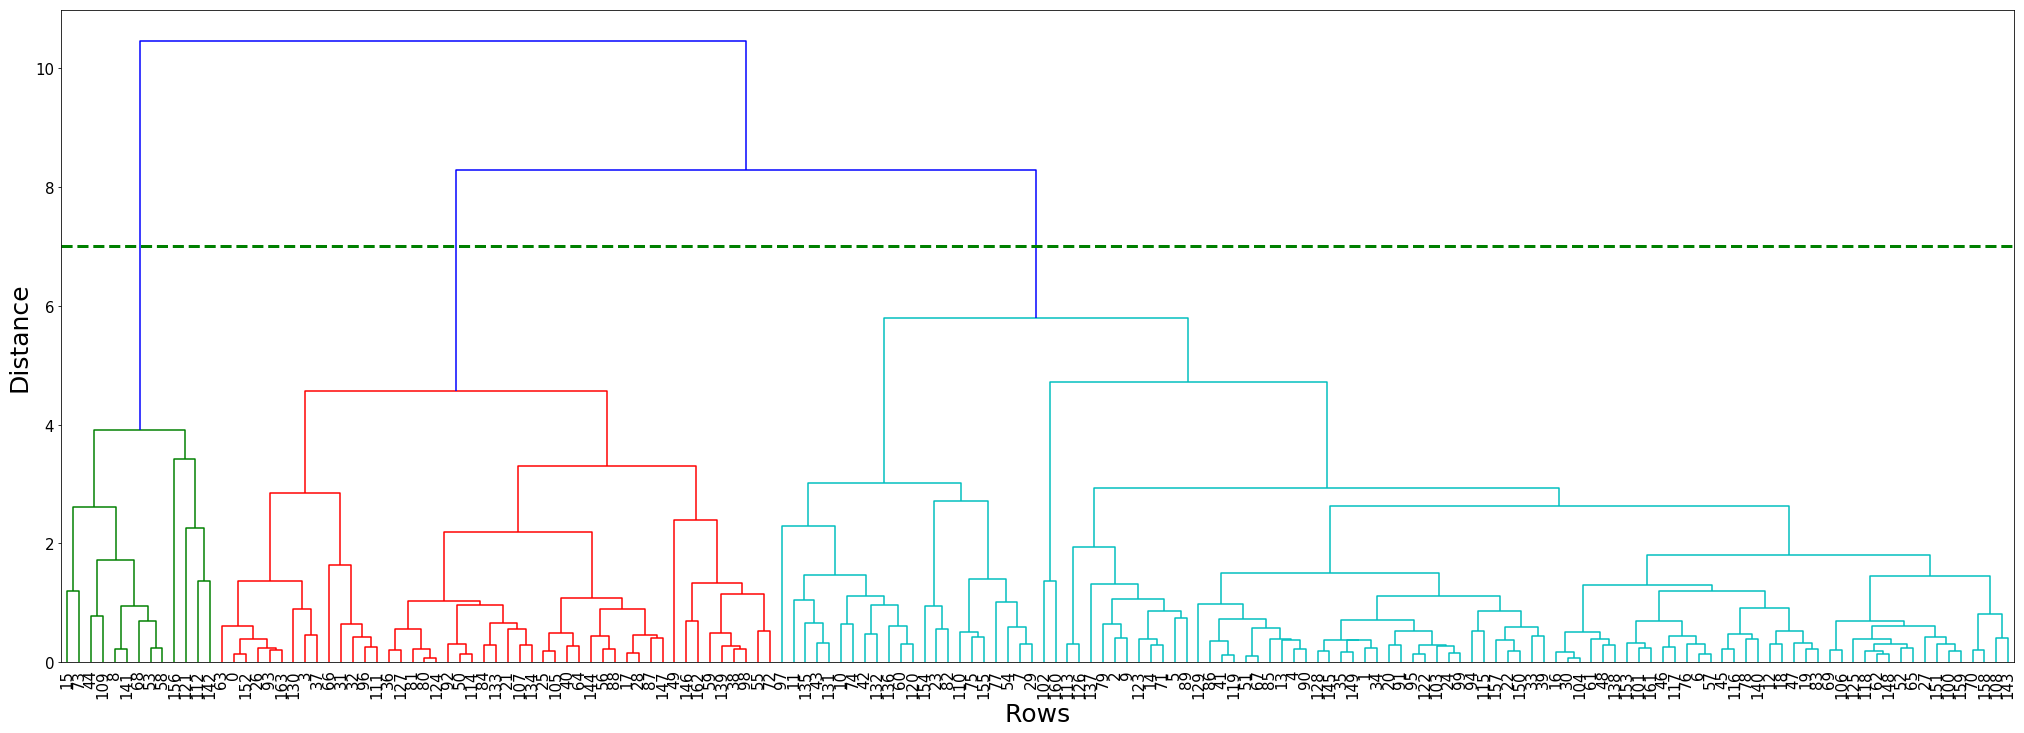

In [86]:
# complete linkage
fig = plt.figure(figsize=(35,12))
mergings = linkage(df_cluster, method='complete', metric='euclidean')
dendrogram(mergings,leaf_font_size =15)
plt.xlabel('Rows',fontsize = 25)
plt.ylabel('Distance',fontsize = 25)
plt.yticks(fontsize = 15)
plt.axhline(y=7, color='g', linestyle='--',linewidth = 3.0)
plt.show()

**The complete linkage method hierarchical clustering is better than the single linkage method!
And we can make the cut on the dendrogram at 7 /8, which will form 3 clusters.**

In [87]:
# let's choose 3 cluster, from business point view, 3 cluster is good to have underdeveloped , developing, developed countries
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 2,
       1, 0, 2, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 0, 0])

In [88]:
# assign the label to the data frame also add countries
df_cluster_Hierar = df_cluster.copy()
df_cluster_Hierar['cluster_id'] = cluster_labels
df_cluster_Hierar['country'] = country_list
df_cluster_Hierar.head()

,PC1,PC2,PC3,PC4,cluster_id,country
0,-2.636647,1.472085,-0.546500,0.237267,0,Afghanistan
1,-0.023845,-1.435816,-0.009080,-0.442921,1,Albania
2,-0.459260,-0.678794,0.967852,-0.176389,1,Algeria
3,-2.723581,2.176018,0.597794,0.438919,0,Angola
4,0.648777,-1.026498,-0.244170,-0.267513,1,Antigua and Barbuda


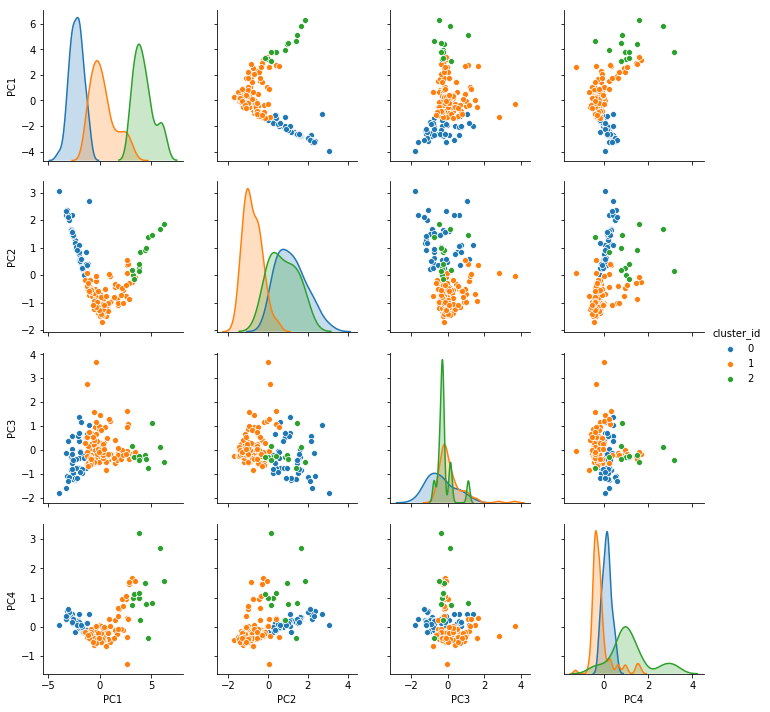

In [89]:
#Check the PCA PCs visualization, about to check how good clusters are formed using pair plot.
Hier_col_list = ['PC1','PC2','PC3','PC4']
sns.pairplot(data = df_cluster_Hierar,x_vars= Hier_col_list,y_vars=Hier_col_list, hue = 'cluster_id')
plt.show()

**Note: Data distribution with respect to clusters is ok but not better than Kmeans clustering results. We can notice from the above pair plots, that cluster 2 distribution is very less and more countries are clustered as developing countries.**

In [90]:
# Assing the cluster labels to the filtered original data set to make some visualizations
df_fil_Hierar = pd.merge(df_fil,df_cluster_Hierar, how= 'inner', on = 'country')
df_fil_Hierar.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,PC1,PC2,PC3,PC4,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,-2.636647,1.472085,-0.546500,0.237267,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,-0.023845,-1.435816,-0.009080,-0.442921,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,-0.459260,-0.678794,0.967852,-0.176389,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,-2.723581,2.176018,0.597794,0.438919,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,0.648777,-1.026498,-0.244170,-0.267513,1


In [91]:
# drop the PCs from the data frame
df_fil_Hierar.drop(Hier_col_list, axis =1, inplace = True)
df_fil_Hierar.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1


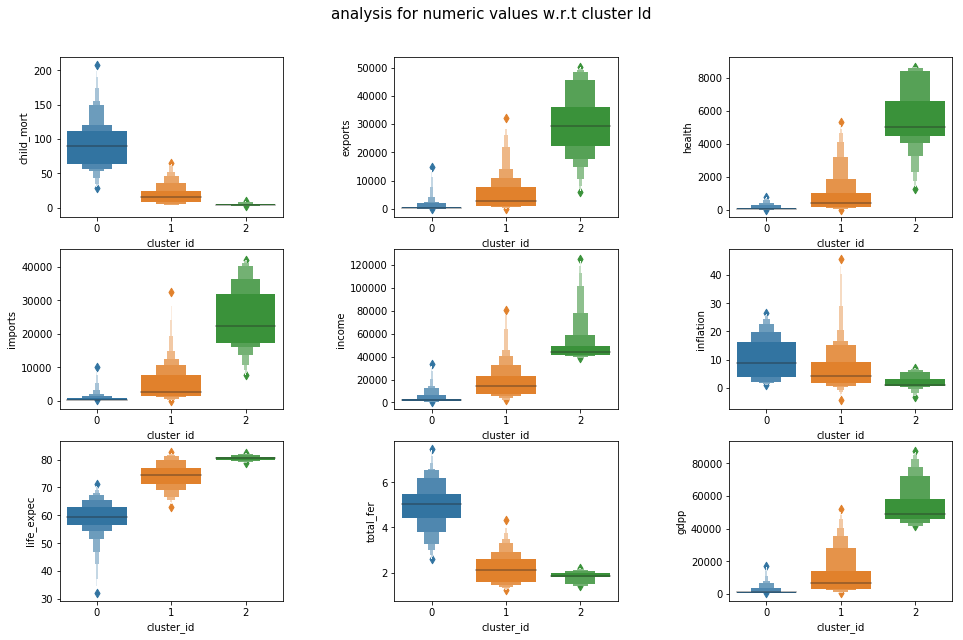

In [92]:
# data distribution using box plots with respect to clusters
fig, axes = plt.subplots(3,3, figsize= (16,10))
count = 0
for i in df_fil_Hierar.columns[1:-1]:
    ax = axes[count//3, count%3]
    sns.boxenplot(y = i, data = df_fil_Hierar, ax = ax, x = 'cluster_id')
    count+=1
fig.suptitle('analysis for numeric values w.r.t cluster Id',fontsize=15,x =0.5, y=0.95)
fig.subplots_adjust(wspace=0.5,hspace=0.2 ) # adjsut spaces between subplots width and height  

**Note: It is clearly seen from the above plots, that cluster 2 indicates developed countries, cluster 1 indicates developing countries and cluster 0 indicates underdeveloped countries. form our business point of view, we are having more concern on cluster 0 to find those countries list, needs support from HELP.** 

In [93]:
# check the mean values of each variabe with respect to clusters
df_fil_Hierar.groupby('cluster_id').mean().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster_id,,,,,,,,,
0,90.79,885.22,114.75,836.00,3870.70,9.95,59.21,4.97,1900.26
1,18.56,5115.82,857.67,4943.14,17679.71,6.72,74.32,2.17,11638.19
2,4.49,29850.23,5520.08,24329.75,51815.38,1.97,80.47,1.84,54723.08


**From the above values:  We can clearly say   
`cluster 0` : 'child_mort' is very high ; 'income' is very less ; 'gdpp' is very less  
`cluster 1` : 'child_mort' risk is modarate ; 'income' is middle range ; 'gdpp' is middle in range  
`cluster 2` : 'child_mort' is very less ; 'income' is very high ; 'gdpp' is very high**  

In [94]:
# we make outer merge to original data frame and df_fil_Hierar. 
# by doing this, we expect some missing values in 'cluster_id', 
# as we try to get the countries which are removed during outlier treatment, now with this those will back to data frame

df_original_with_hierar = pd.merge(df_fil,df_fil_Hierar[['country','cluster_id']],how='outer',on= 'country')

In [95]:
# check the dataframe shape, should be 167 rows.
df_original_with_hierar.shape

(167, 11)

In [96]:
df_original_with_hierar.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0.0
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1.0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1.0
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0.0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1.0


In [97]:
# check for missing values, expect to have 3 missing values from "cluster_id"
df_original_with_hierar.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    3
dtype: int64

In [98]:
# check the countries having missing cluster_id, let's recall that we removed 3 countries during outlier treatment.
# 'Luxembourg', 'Nigeria' & 'Singapore'

df_original_with_hierar.loc[df_original_with_hierar['cluster_id'].isnull()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
91,Luxembourg,2.8,183750.00,8158.500,149100.00,91700,3.620,81.3,1.63,105000,NaN
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330,NaN
133,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600,NaN


**From the above values:  We can clearly say   
`cluster 0` : 'child_mort' is very high ; 'income' is very less ; 'gdpp' is very less  
`cluster 1` : 'child_mort' risk is modarate ; 'income' is middle range ; 'gdpp' is middle in range  
`cluster 2` : 'child_mort' is very less ; 'income' is very high ; 'gdpp' is very high**      

***this is very clear from the data visualization and the mean values. "Nigeria will come under cluster 0 and remaining 2 countries will come under cluster 2. let's take "child_mort" column as a reference to impute NaN values***

In [99]:
values =[]
for i in df_original_with_hierar.values:
    if (abs(i[1]-90.79) < abs(i[1]-4.49)) & (abs(i[1]-90.79) < abs(i[1]-18.56)):
        values.append(0)
    elif (abs(i[1]-4.49) < abs(i[1]-90.79)) & (abs(i[1]-4.49) < abs(i[1]-18.56)):
        values.append(2)
    else:
        values.append(1)
        
# create columns in the data frame to impute missing values in cluster id
df_original_with_hierar['values'] = values

In [100]:
df_original_with_hierar.loc[df_original_with_hierar['cluster_id'].isnull()]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,values
91,Luxembourg,2.8,183750.00,8158.500,149100.00,91700,3.620,81.3,1.63,105000,NaN,2
113,Nigeria,130.0,589.49,118.131,405.42,5150,104.000,60.5,5.84,2330,NaN,0
133,Singapore,2.8,93200.00,1845.360,81084.00,72100,-0.046,82.7,1.15,46600,NaN,2


**as per our understanding, the values are giving correct cluster numbers. so we can impute NaN with corresponding values from Values column**

In [101]:
# impute the missing values of cluster_id
df_original_with_hierar['cluster_id'].replace(to_replace=np.nan, value = df_original_with_hierar['values'],inplace= True)

In [102]:
#drop the values columns!.
df_original_with_hierar.drop(columns = 'values', inplace = True)

In [103]:
# check for missing values. should be no missing values
df_original_with_hierar.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
cluster_id    0
dtype: int64

In [104]:
# Life Expectancy Index ( LEI) = (life_expec-20) / 85-20
# LEI is 1 when Life expectancy at birth is 85 and 0 when Life expectancy at birth is 20.

LEI = (df_original_with_hierar['life_expec'] - 20)/65

# Income index (Income_index) = ln(gdpp) -ln(100)/ ln(75000) - ln(100)
# Income_index is 1 when gdp per capita is 75,000 and 0 when GNI per capita is 100.

Income_index =(np.log(df_original_with_hierar['gdpp']) - np.log(100)) / (np.log(75000) - np.log(100))

# HDI is the geometric mean of the previous two normalized indices ( 'LEI' & 'Income_index')
df_original_with_hierar['HDI'] = np.sqrt(LEI*Income_index).round(2)
df_original_with_hierar.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,HDI
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,0.0,0.38
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,1.0,0.70
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,1.0,0.71
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,0.0,0.58
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,1.0,0.80


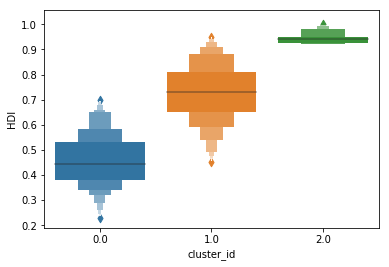

In [105]:
# plot the HDI derived metric with respect to clusters.
sns.boxenplot(y = 'HDI', data = df_original_with_hierar, x = 'cluster_id')
plt.show()

**Note: Cluster 0 distribution is much similar to Kmeans cluster 0 than other clusters. Considering business out target is to find the direst need of countries and those come under cluster 0. Let's check how the cluster 0 and others are distributed respect to each variable in the next following steps...** 

In [106]:
# create a dictionary of cluster labels and apply on clusters id columns
cluster_lables_dict = dict({0:'Under_develop_countries', 1:'Developing_countries',2:'Developed_countries'})
df_original_with_hierar['cluster_id'] = df_original_with_hierar['cluster_id'].apply(lambda X:cluster_lables_dict[X])

In [107]:
# check the country's distribution among the clusters. Underdeveloped countries are 48
df_original_with_hierar.groupby('cluster_id').count()['country']

cluster_id
Developed_countries         15
Developing_countries       104
Under_develop_countries     48
Name: country, dtype: int64

**The list of countries direst need of aid is 48. Which is the same as the Kmeans clustering result. lets make a further check with respect to HDI values, to make priorities in consideration**

In [108]:
df_original_with_hierar.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,HDI
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553,Under_develop_countries,0.38
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090,Developing_countries,0.70
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460,Developing_countries,0.71
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530,Under_develop_countries,0.58
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200,Developing_countries,0.80


### Business aspect: we need to make analysis by considering 'child_mort', 'heath', 'income', 'life_expec', 'gdpp' and 'HDI'

In [109]:
# filter the columns, considering as per business aspects and create the list for use in making pair plots
columns_list_pairplot_hierar = df_original_with_hierar.columns[1:].drop(['exports','imports','inflation','total_fer',
                                                                         'cluster_id'])
columns_list_pairplot_hierar

Index(['child_mort', 'health', 'income', 'life_expec', 'gdpp', 'HDI'], dtype='object')

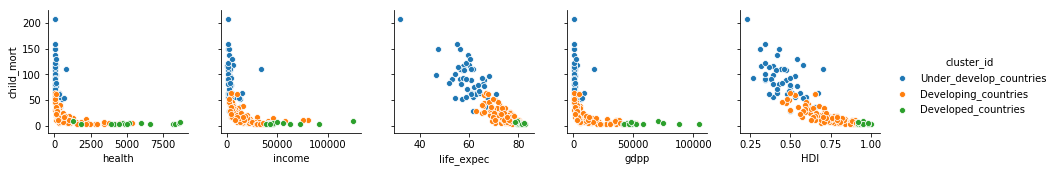

In [110]:
# scatter plot of child_mort with respect to 'health','income','life_expec','gdpp','HDI'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('child_mort')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='child_mort', 
                               hue='cluster_id')
plt.show()

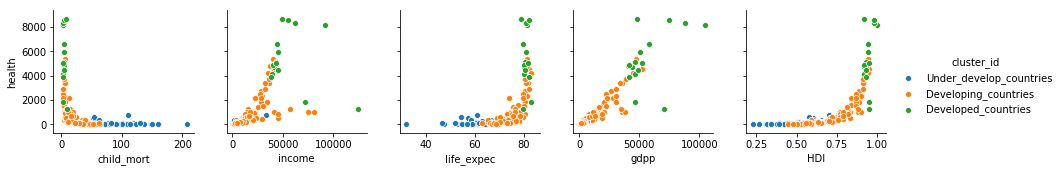

In [111]:
# scatter plot of child_mort with respect to 'child_mort','income','life_expec','gdpp','HDI'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('health')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='health', 
                               hue='cluster_id')
plt.show()

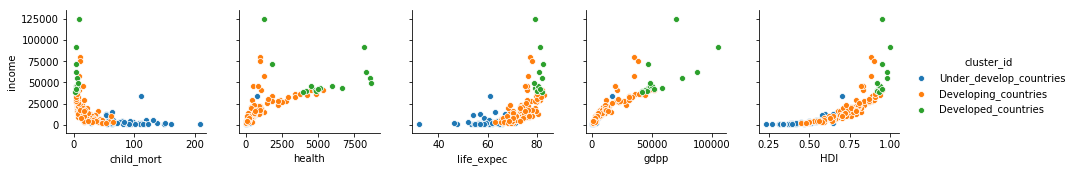

In [112]:
# scatter plot of child_mort with respect to 'child_mort','health','life_expec','gdpp','HDI'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('income')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='income', 
                               hue='cluster_id')
plt.show()

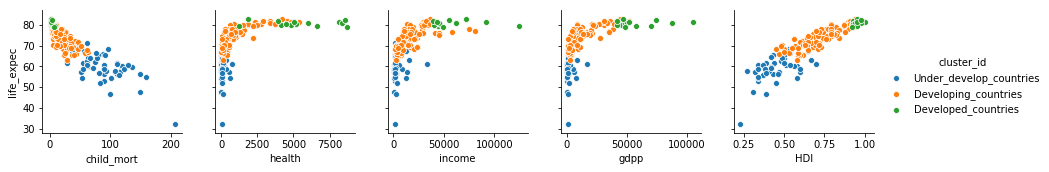

In [113]:
# scatter plot of child_mort with respect to 'child_mort','health','income','gdpp','HDI'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('life_expec')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='life_expec', 
                               hue='cluster_id')
plt.show()

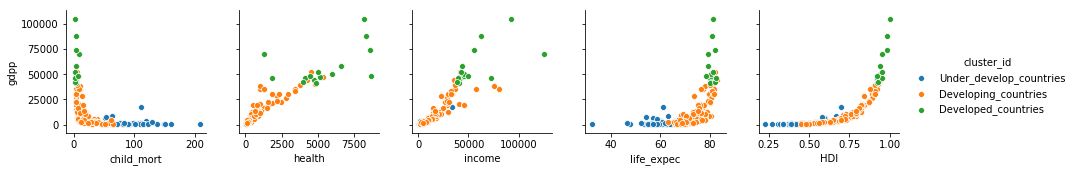

In [114]:
# scatter plot of child_mort with respect to 'child_mort','health','income','life_expec','HDI'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('gdpp')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='gdpp', 
                               hue='cluster_id')
plt.show()

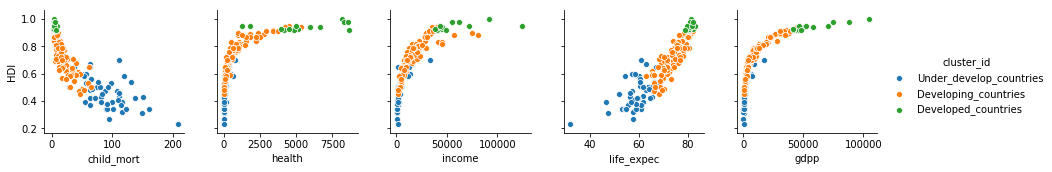

In [115]:
# scatter plot of child_mort with respect to 'child_mort','health','income','life_expec','gdpp'
temp_colums_list_pairplot_hierar = columns_list_pairplot_hierar.drop('HDI')
fig_pairplot_hc = sns.pairplot(data = df_original_with_hierar,x_vars =temp_colums_list_pairplot_hierar,y_vars ='HDI', 
                               hue='cluster_id')
plt.show()

**From the above scatter plots, it is very clear that developed countries ( cluster 2 ) distribution is very less for come variables compared to Kmeans. 
But good thing is that our business target cluster 0 seems giving the same result both in Kmeans and Hierarchical clustering.**

In [116]:
# check the mean values of each cluster, HDI mean is 0.46 for underdeveloped countries
df_original_with_hierar.groupby('cluster_id').mean().round(2)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,HDI
cluster_id,,,,,,,,,,
Developed_countries,4.27,44333.53,5450.99,36431.38,55826.67,1.95,80.67,1.78,57533.33,0.94
Developing_countries,18.56,5115.82,857.67,4943.14,17679.71,6.72,74.32,2.17,11638.19,0.73
Under_develop_countries,91.61,879.06,114.82,827.03,3897.35,11.91,59.24,4.99,1909.21,0.46


In [117]:
# create new data frame with having only Underdeveloped countries( cluster 0) data
df_Hierar_UDC = df_original_with_hierar.loc[df_original_with_hierar['cluster_id']=='Under_develop_countries']
df_Hierar_UDC.drop(columns= ['exports','imports','inflation','total_fer'], inplace = True)
df_Hierar_UDC.head()

,country,child_mort,health,income,life_expec,gdpp,cluster_id,HDI
0,Afghanistan,90.2,41.9174,1610,56.2,553,Under_develop_countries,0.38
3,Angola,119.0,100.6050,5900,60.1,3530,Under_develop_countries,0.58
17,Benin,111.0,31.0780,1820,61.8,758,Under_develop_countries,0.44
21,Botswana,52.5,527.0500,13300,57.1,6350,Under_develop_countries,0.60
25,Burkina Faso,116.0,38.7550,1430,57.9,575,Under_develop_countries,0.39


In [118]:
# check the result of cluster 0 ( underdeveloped countries ) list is same for both kmeans and hierarchical clustering
df_kmeans_UDC['country'].values == df_Hierar_UDC['country'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

**The results of cluster 0 is same for both Kmeans and Hierarchical clustering.**

In [119]:
# create a dictionary with mean values of each column
d_ref_values_hier = df_Hierar_UDC.groupby('cluster_id').mean().round(2).reset_index().drop(columns='cluster_id').to_dict('list')
d_ref_values_hier

{'child_mort': [91.61],
 'health': [114.82],
 'income': [3897.35],
 'life_expec': [59.24],
 'gdpp': [1909.21],
 'HDI': [0.46]}

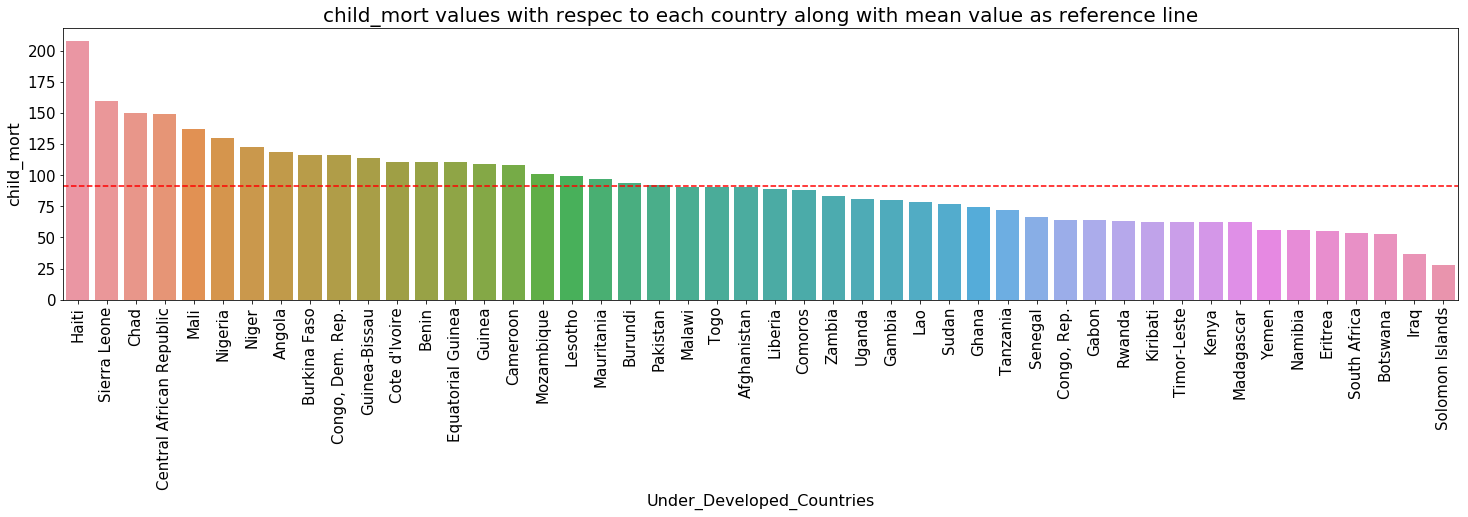

Dire need of aid 20 countries list_child_mort:: 

Haiti
Sierra Leone
Chad
Central African Republic
Mali
Nigeria
Niger
Angola
Congo, Dem. Rep.
Burkina Faso
Guinea-Bissau
Cote d'Ivoire
Equatorial Guinea
Benin
Guinea
Cameroon
Mozambique
Lesotho
Mauritania
Burundi


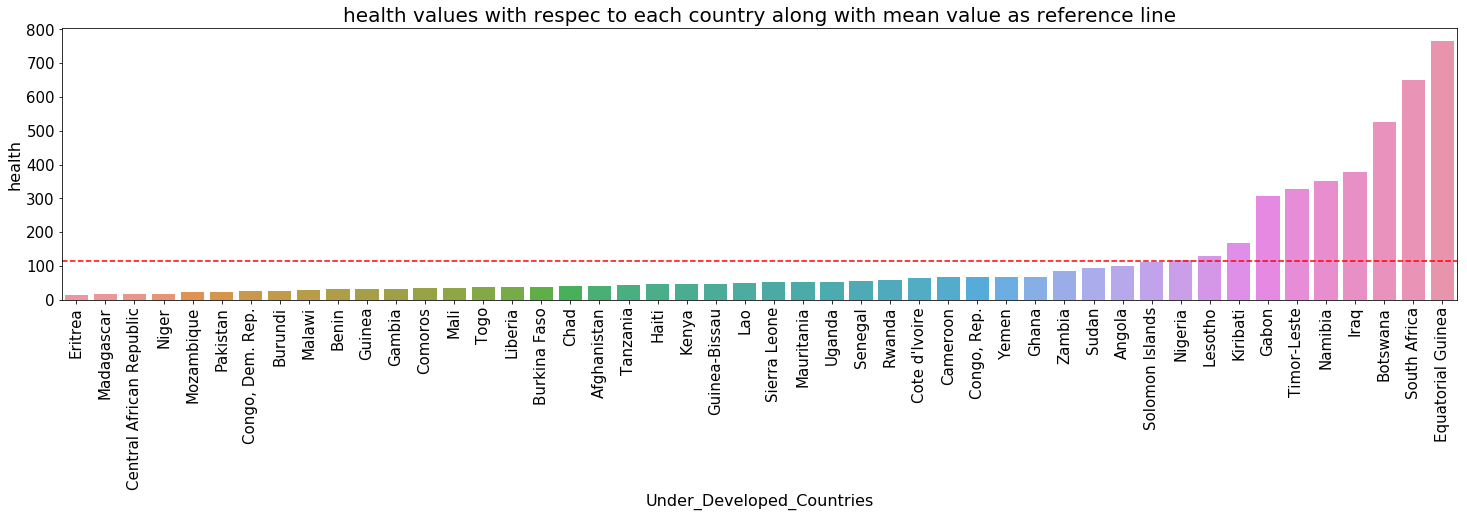

Dire need of aid 20 countries list_health:: 

Eritrea
Madagascar
Central African Republic
Niger
Mozambique
Pakistan
Congo, Dem. Rep.
Burundi
Malawi
Benin
Guinea
Gambia
Comoros
Mali
Togo
Liberia
Burkina Faso
Chad
Afghanistan
Tanzania


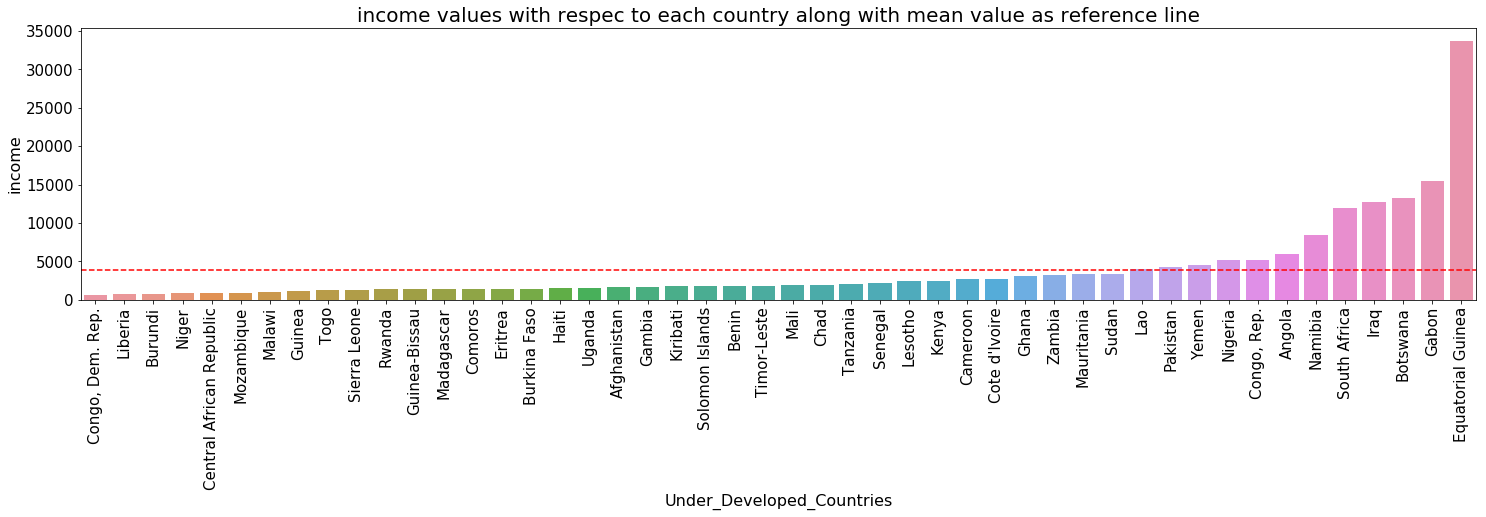

Dire need of aid 20 countries list_income:: 

Congo, Dem. Rep.
Liberia
Burundi
Niger
Central African Republic
Mozambique
Malawi
Guinea
Togo
Sierra Leone
Rwanda
Madagascar
Guinea-Bissau
Comoros
Eritrea
Burkina Faso
Haiti
Uganda
Afghanistan
Gambia


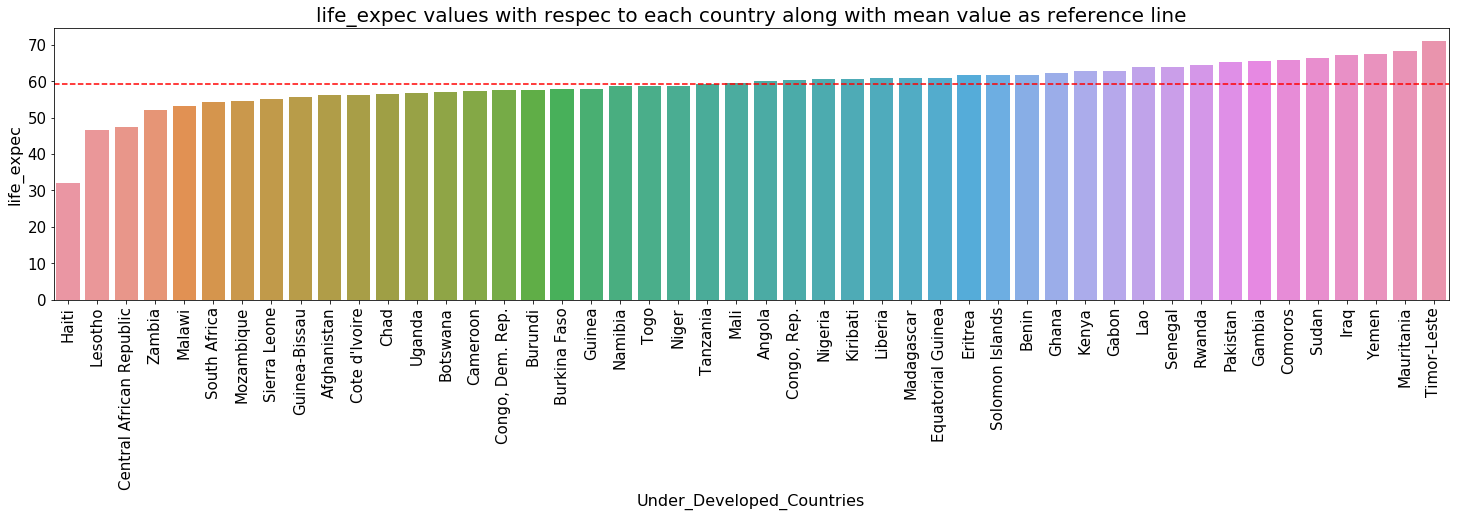

Dire need of aid 20 countries list_life_expec:: 

Haiti
Lesotho
Central African Republic
Zambia
Malawi
South Africa
Mozambique
Sierra Leone
Guinea-Bissau
Afghanistan
Cote d'Ivoire
Chad
Uganda
Botswana
Cameroon
Congo, Dem. Rep.
Burundi
Burkina Faso
Guinea
Namibia


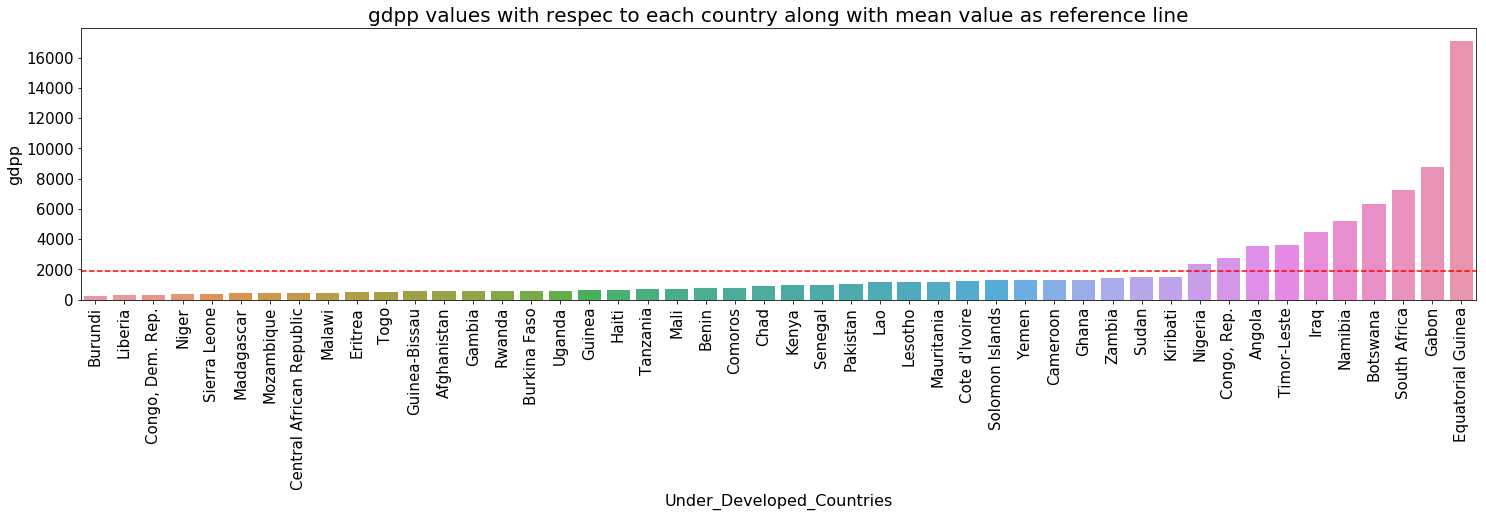

Dire need of aid 20 countries list_gdpp:: 

Burundi
Liberia
Congo, Dem. Rep.
Niger
Sierra Leone
Madagascar
Mozambique
Central African Republic
Malawi
Eritrea
Togo
Guinea-Bissau
Afghanistan
Gambia
Rwanda
Burkina Faso
Uganda
Guinea
Haiti
Tanzania


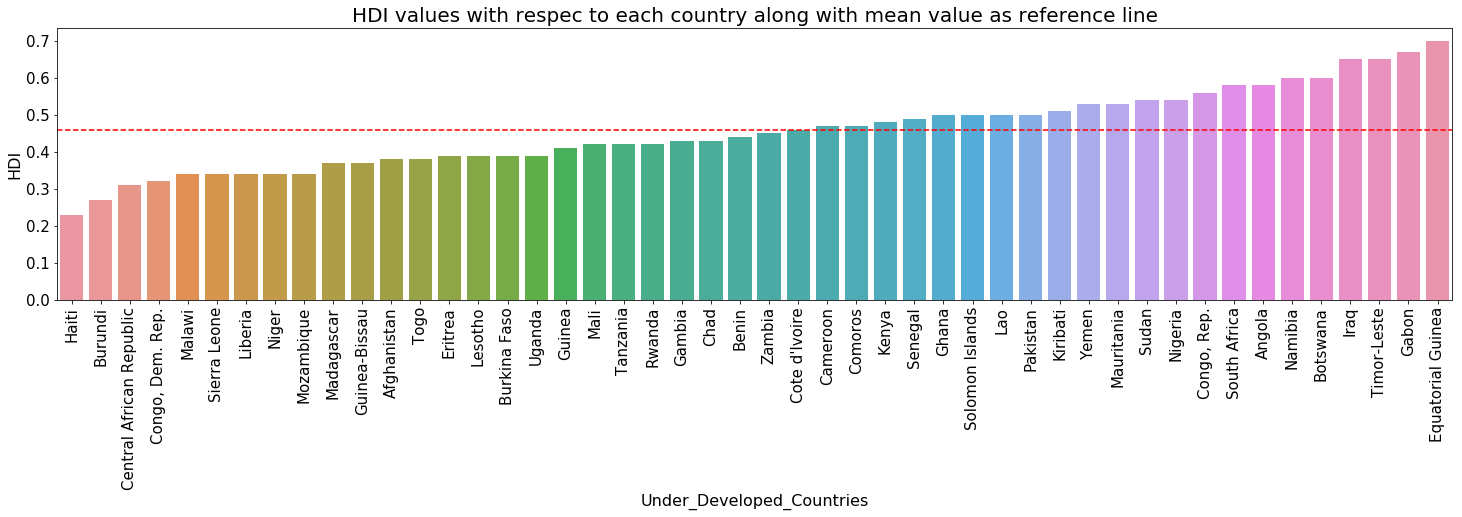

Dire need of aid 20 countries list_HDI:: 

Haiti
Burundi
Central African Republic
Congo, Dem. Rep.
Sierra Leone
Niger
Mozambique
Malawi
Liberia
Madagascar
Guinea-Bissau
Togo
Afghanistan
Lesotho
Eritrea
Burkina Faso
Uganda
Guinea
Mali
Rwanda


In [120]:
# ploting each variables data with respect to countries and return priority 20 countries from each variables data
Ascend_dict = {1:False,2:True,3:True,4:True,5:True,6:True}
count = 1
Hierar_dire_need_Countries = pd.DataFrame()
for i in columns_list_pairplot:
    Hierar_dire_need_Countries[i] = barplot_for_each_column_w_r_t_country(df_Hierar_UDC,i,Ascend_dict[count],d_ref_values_hier)
    count = count+1
    

In [121]:
# list of top 20 countries direst need of aid from each variables
Hierar_dire_need_Countries

,child_mort,health,income,life_expec,gdpp,HDI
0,Haiti,Eritrea,"Congo, Dem. Rep.",Haiti,Burundi,Haiti
1,Sierra Leone,Madagascar,Liberia,Lesotho,Liberia,Burundi
2,Chad,Central African Republic,Burundi,Central African Republic,"Congo, Dem. Rep.",Central African Republic
3,Central African Republic,Niger,Niger,Zambia,Niger,"Congo, Dem. Rep."
4,Mali,Mozambique,Central African Republic,Malawi,Sierra Leone,Sierra Leone
5,Nigeria,Pakistan,Mozambique,South Africa,Madagascar,Niger
6,Niger,"Congo, Dem. Rep.",Malawi,Mozambique,Mozambique,Mozambique
7,Angola,Burundi,Guinea,Sierra Leone,Central African Republic,Malawi
8,"Congo, Dem. Rep.",Malawi,Togo,Guinea-Bissau,Malawi,Liberia
9,Burkina Faso,Benin,Sierra Leone,Afghanistan,Eritrea,Madagascar


In [122]:
# Create the list of countries from the "Hierar_dire_need_Countries" dataframe
Hierar_countries_list = []
for i in Hierar_dire_need_Countries.values:
    for j in i:
        Hierar_countries_list.append(j)

Need_of_aid_list_hierar = list(set(Hierar_countries_list))

In [123]:
# Sort the HDI values to get priorities of countries which we need as per business aspect

df_dire_of_aid_hc = pd.merge(df_Hierar_UDC[['country','HDI']],
                             pd.DataFrame(Need_of_aid_list_hierar,columns=['country']),how='inner')

df_dire_of_aid_hc.sort_values('HDI', inplace = True)
df_dire_of_aid_hc.head()

,country,HDI
17,Haiti,0.23
5,Burundi,0.27
7,Central African Republic,0.31
10,"Congo, Dem. Rep.",0.32
30,Sierra Leone,0.34


In [124]:
# print the countries direst need of help
print('\033[1m'+'\033[4m'+'\033[92m'+'Hierar_cluster_Dire need of aid '+str(len(df_dire_of_aid_hc.country.values))+
      ' countries list: \n'+'\033[0m')
for i in list(df_dire_of_aid_hc.country.values):
    print('\033[1m'+'\033[92m'+i)

Hierar_cluster_Dire need of aid 36 countries list: 

Haiti
Burundi
Central African Republic
Congo, Dem. Rep.
Sierra Leone
Niger
Mozambique
Malawi
Liberia
Madagascar
Guinea-Bissau
Togo
Afghanistan
Eritrea
Lesotho
Uganda
Burkina Faso
Guinea
Tanzania
Mali
Rwanda
Gambia
Chad
Benin
Zambia
Cote d'Ivoire
Cameroon
Comoros
Pakistan
Mauritania
Nigeria
South Africa
Angola
Namibia
Botswana
Equatorial Guinea


**Need for aid countries listed as per priority wise. Priority considered as per their HDI values. Lowest HDI becomes the highest priority for the direst need of aid and vice versa.**    

In [125]:
# list of total direst need of aid countries
print(df_kmeans_UDC['country'].values)

['Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tanzania' 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia']


In [126]:
# Top priority 15 direst need of aid countries with respec to HDI
print(df_dire_of_aid.country.values[:15])

['Haiti' 'Burundi' 'Central African Republic' 'Congo, Dem. Rep.'
 'Sierra Leone' 'Niger' 'Mozambique' 'Malawi' 'Liberia' 'Madagascar'
 'Guinea-Bissau' 'Togo' 'Afghanistan' 'Eritrea' 'Lesotho']


In [127]:
#If there is a possibility to help more countries then the next top priority 20 countries as follows
print(df_dire_of_aid.country.values[15:-1])

['Uganda' 'Burkina Faso' 'Guinea' 'Tanzania' 'Mali' 'Rwanda' 'Gambia'
 'Chad' 'Benin' 'Zambia' "Cote d'Ivoire" 'Cameroon' 'Comoros' 'Pakistan'
 'Mauritania' 'Nigeria' 'South Africa' 'Angola' 'Namibia' 'Botswana']


# Summary:  

* Covert the % columns to absolute values, as I noticed that absolute values are giving more accurate details than percentage.
* Apply standard scaling to keep all variables in the same magnitude.
* Outliers checked on the data before PCA, found 4 countries detected as outliers with +/-5% outlier detection. Decided to no to remove before PCA.  
* Perform PCA on the data, to make dimensions reduction for better visualization and clustering the data and also to avoid multicollinearity. After PCA checked multicollinearity, noted that it became absolutely fine.  
* Perform outlier detection after PCA, detected 3 countries as outliers. Removed these 3 countries before applying a clustering algorithm, as K-means is outliers sensitive. Once clustering is done, we can reconsider those outliers and assing proper cluster with the learning out of clustering data.   
* Consider 4 principal components, which have about to explain 93% of data variance.  
* Check elbow curve & silhouette score to decide the number of clusters for this data. The suitable number of clusters is 3. Also for the business requirement will fulfill with 3 clusters. The 3 clusters can be labeled as Under Development Countries, Developing Countries, Developed Countries.  
* Clusters 0: Under Development Countries ( direst need of aid )   = 48 countries
    o	Child_mort: High  
    o	Income: Low  
    o	GDPP: Low  
* Cluster 1: Developing Countries  = 88 countries
    o	Child_mort: Middle range  
    o	Income: Middle range  
    o	GDPP: Middle range  
* Cluster 2: Developed Countries  = 31 countries
    o	Child_mort: Low  
    o	Income: High  
    o	GDPP: High  
    
**`cluster 0` : 'child_mort' is very high ; 'income' is very less ; 'gdpp' is very less  
`cluster 1` : 'child_mort' risk is modarate ; 'income' is middle range ; 'gdpp' is middle in range  
`cluster 2` : 'child_mort' is very less ; 'income' is very high ; 'gdpp' is very high**  

* After clustering, consider the removed countries during outliers and impute the cluser id using ‘child_mort’ column data.

**Derive Human Development Index ( HDI ):**  
***1.HDI calculation comes out from "life expectancy index" , "Education index" and "Income index".  
2.Since we dont have any details about "Education index", we try to calculated geometric mean of "life expectancy index" and "Income index"***
  
**reference link: https://en.wikipedia.org/wiki/Human_Development_Index**

* Out of 48 direst need of aid countries, around 36 countries are listed with priority considering its life expectancy and Gdpp.
* **`list of 48 direst need of aid countries list:`**  

**'Afghanistan' 'Angola' 'Benin' 'Botswana' 'Burkina Faso' 'Burundi'
 'Cameroon' 'Central African Republic' 'Chad' 'Comoros' 'Congo, Dem. Rep.'
 'Congo, Rep.' "Cote d'Ivoire" 'Equatorial Guinea' 'Eritrea' 'Gabon'
 'Gambia' 'Ghana' 'Guinea' 'Guinea-Bissau' 'Haiti' 'Iraq' 'Kenya'
 'Kiribati' 'Lao' 'Lesotho' 'Liberia' 'Madagascar' 'Malawi' 'Mali'
 'Mauritania' 'Mozambique' 'Namibia' 'Niger' 'Nigeria' 'Pakistan' 'Rwanda'
 'Senegal' 'Sierra Leone' 'Solomon Islands' 'South Africa' 'Sudan'
 'Tanzania' 'Timor-Leste' 'Togo' 'Uganda' 'Yemen' 'Zambia'**  
 
**`Also performed Hierarchical clustering:`
Single linkage clusters are not formed well. So checked with complete linkage, which is showing better clusters than single linkage. So proceed with complete linkage clusters. Demdograme cut at the distance of 8, result 3 clusters. 
And proceed further just like the K-means cluster algorithm and at the end, the Hierarchical cluster algorithm also returns the same 48 countries. But K-means algorithms results more towards realistic with respect to developed and developing countries list.
Form a business target point of view, underdeveloped countries are listed the same from Kmeans and Hierarchical algorithm.**
  
  
  
  
## **`Here are the Top priority  15 countries need to focus on priority:`**  
### **'Haiti' 'Burundi' 'Central African Republic' 'Congo, Dem. Rep.' 'Sierra Leone' 'Niger' 'Mozambique' 'Malawi' 'Liberia' 'Madagascar' 'Guinea-Bissau' 'Togo' 'Afghanistan' 'Eritrea' 'Lesotho'**  
  
  
  
  
## **`If there is a possibility to help more countries then the next top priority 20 countries as follows`:**  
### **'Uganda' 'Burkina Faso' 'Guinea' 'Tanzania' 'Mali' 'Rwanda' 'Gambia' 'Chad' 'Benin' 'Zambia' "Cote d'Ivoire" 'Cameroon' 'Comoros' 'Pakistan' 'Mauritania' 'Nigeria' 'South Africa' 'Angola' 'Namibia' 'Botswana'**

 
